# Machine Learning for prediction

## Purpose
This project aims to use Machine learning in order to cast a prediction of the Electrical Expenditures in the residential sector for the year 2021

## Background
EIA's State Energy Data System (SEDS) is a comprehensive data set that consists of annual time series estimates of state-level energy use by major economic sectors, energy production and and State-level energy price and expenditure data. The system provides data back from 1960. Data are presented in physical units, BTUs, and dollars. While some SEDS data series come directly from surveys conducted by EIA, many are estimated using other available information. These estimations are necessary for the compilation of "total energy" estimates.

Useful Links:

The main website: https://catalog.data.gov/dataset/state-energy-data-system-seds

Additional information: https://www.eia.gov/state/seds/

Codes and descriptions: https://www.eia.gov/state/seds/CDF/Codes_and_Descriptions.xlsx


From the State Data energy System description sheets: \
The MSNs are five-character codes, most of which are structured as follows:
First and second characters - describes an energy source (for example, NG for natural gas, MG for motor gasoline)
Third and fourth characters - describes an energy sector or an energy activity (for example, RC for residential consumption, PR for production)
Fifth character - describes a type of data (for example, P for data in physical unit, B for data in billion Btu and D is for dollars per million BTU)


The aim of this project is to predict the Primary average price in the residential sector for the year 2021 based on residentail sector features.

## Data Loading, cleaning, visualization

In [1]:

import pandas as pd
import pyarrow as pa
import os
import zipfile
import matplotlib.pyplot as plt 
from collections import Counter
import numpy as np
import statsmodels.api as sm
import pylab
import scipy.stats as stats
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
import statsmodels.api as sm
import pylab
import scipy.stats as stats

pd.options.display.float_format = '{:.2f}'.format

### Importing Files Here

In [2]:
#pip freeze > requirements.txt
#aaaagggg
os.getcwd()
os.chdir('c:\\Users\\amcfa\\gitfiles\\Projects\\MastersWork\\shorter_ML_Projects\\Machine-Learning-_-Prediction')
file = pd.read_csv(os.getcwd()+ '\Complete_SEDS.csv')
file1=file
codes = pd.read_csv(os.getcwd()+ '/residential_sector_codes.csv')
codes.head(1)

When loaded the file contains several columns: \
`Data_Status` - A Code \
`MSN` - A 5 letter combination to signify energy source, sector and unit of data.\
Units for each category are given below.\
Please see :https://www.eia.gov/state/seds/CDF/Codes_and_Descriptions.xlsx for a full description of each category.
*	Million Btu per short ton
*	Billion Btu
*	Dollars per million Btu
*	Thousand short tons
*	Million dollars
*	Thousand barrels

`StateCode` Two letter state abbreviation \
`Year` YYYY-MM-DD \
`Data` Numerical - associated with MSN 


In [59]:
file1

Data_Status    MSN StateCode       Year    Data
0             2021F  ABICB        AK 1960-01-01    0.00
1             2021F  ABICB        AK 1961-01-01    0.00
2             2021F  ABICB        AK 1962-01-01    0.00
3             2021F  ABICB        AK 1963-01-01    0.00
4             2021F  ABICB        AK 1964-01-01    0.00
...             ...    ...       ...        ...     ...
2007506       2021F  ZWHDP        WY 2017-01-01 7903.00
2007507       2021F  ZWHDP        WY 2018-01-01 8180.00
2007508       2021F  ZWHDP        WY 2019-01-01 8915.00
2007509       2021F  ZWHDP        WY 2020-01-01 8079.00
2007510       2021F  ZWHDP        WY 2021-01-01 7874.00

[1967191 rows x 5 columns]

### Data Inspection, cleaning

After loading the data, I will inspect it. 
A few possible ways are below. 

1) Using the .describe() function. Which shows the numerical distribution of the data.

In [57]:
file1.describe()

Year        Data
count                        1967191  1967191.00
mean   1993-01-26 12:41:18.894626688    52486.32
min              1960-01-01 00:00:00  -770830.00
25%              1979-01-01 00:00:00        0.40
50%              1993-01-01 00:00:00       71.00
75%              2008-01-01 00:00:00     5908.00
max              2021-01-01 00:00:00 23843751.00
std                              NaN   300923.55

2. As well as using the dtype function. Which shows that Data is a float column, so there are no Nan variables or strings present.

In [56]:
file1.dtypes

Data_Status            object
MSN                    object
StateCode              object
Year           datetime64[ns]
Data                  float64
dtype: object

3. Using the isna function to see if there are any na values anywhere.

In [53]:
empty_rows = file1[file1.isna().any(axis=1)]
print('There are',len(empty_rows),"empty rows")

There are 0 empty rows


Updating the year to be a datetime object will make working with the dataframe much simpler.
Additionally since I am not estimating the expenditures for the United States as a whole. I will exclude this column.

In [5]:
file1['Year'] = pd.to_datetime(file1['Year'], format='%Y')
file1=file1[~(file1['StateCode']=='US')]

Creating a list of relevant features

In [8]:
pqr = codes['CLHCK'].unique() #Taking the unique list of codes
abc = len(pqr) #The length of codes
new_list_of_titles = []
dfs = []
for i in pqr:
	if i not in new_list_of_titles:
		new_list_of_titles.append(i)
print(new_list_of_titles)




['CLRCB', 'CLRCD', 'CLRCP', 'CLRCV', 'DFRCB', 'DFRCD', 'DFRCP', 'DFRCV', 'GERCB', 'HLRCB', 'HLRCD', 'HLRCP', 'HLRCV', 'KSRCB', 'KSRCD', 'KSRCP', 'KSRCV', 'LORCB', 'NGRCB', 'NGRCD', 'NGRCP', 'NGRCV', 'PARCB', 'PARCD', 'PARCK', 'PARCP', 'PARCV', 'PERCD', 'PERCV', 'PERSB', 'PQRCB', 'PQRCD', 'PQRCP', 'PQRCV', 'SFRCB', 'SOR7P', 'SORCB', 'SOTCB', 'SOTGP', 'SOTXB', 'TERCB', 'TERCD', 'TERCV', 'TERPB', 'TNRCB', 'TNRSB', 'WDRCB', 'WDRCD', 'WDRCV', 'WDRSB', 'WDRXB']


Transposing the data so it will be easier to work with

In [9]:
general_consumption= file1[file1['MSN'].str.contains('ESRCV')]
# Convert new_list_of_titles to a single regex pattern
pattern1 = '|'.join(new_list_of_titles)

# Use str.contains() with the regex pattern
filtered_df11 = file1[file1['MSN'].str.contains(pattern1)]
merged_data = pd.merge(general_consumption, filtered_df11, on=["StateCode", "Year", "Data_Status"], how="left")
import pandas as pd
pivoted_data = merged_data.pivot_table(index=["StateCode", "Year", "Data_Status","MSN_x","Data_x"], columns="MSN_y", values="Data_y", aggfunc="first")
# Reset index to flatten the dataframe
pivoted_data.reset_index(inplace=True)

In [13]:
pivoted_data.head(10)

MSN_y StateCode       Year Data_Status  MSN_x  Data_x  CLRCB  CLRCD  CLRCP  \
0            AK 1970-01-01       2021F  ESRCV   16.70 233.00   2.47  13.00   
1            AK 1971-01-01       2021F  ESRCV   20.10 177.00   2.40  10.00   
2            AK 1972-01-01       2021F  ESRCV   22.00 199.00   2.28  11.00   
3            AK 1973-01-01       2021F  ESRCV   22.30  92.00   2.44   5.00   
4            AK 1974-01-01       2021F  ESRCV   25.30  92.00   2.54   5.00   
5            AK 1975-01-01       2021F  ESRCV   31.10  88.00   2.87   5.00   
6            AK 1976-01-01       2021F  ESRCV   36.60  71.00   2.78   4.00   
7            AK 1977-01-01       2021F  ESRCV   44.80  69.00   2.86   4.00   
8            AK 1978-01-01       2021F  ESRCV   49.70   0.00   0.00   0.00   
9            AK 1979-01-01       2021F  ESRCV   49.20   0.00   0.00   0.00   

MSN_y  CLRCV    DFRCB  ...  TERCD  TERCV  TERPB    TNRCB    TNRSB   WDRCB  \
0       0.60  7932.00  ...   2.30  38.90  81.80 17800.00 16912.00 1290.00   
1       0.40 10433.00  ...   2.34  47.70  93.80 21282.00 20418.00 1256.00   
2       0.50  8220.00  ...   2.49  49.00  90.80 20497.00 19681.00 1187.00   
3       0.20 10014.00  ...   2.73  49.80  86.20 19008.00 18263.00 1084.00   
4       0.20 10041.00  ...   3.44  61.50  85.40 18605.00 17871.00 1066.00   
5       0.30  9441.00  ...   3.23  78.10  96.10 25137.00 24166.00 1410.00   
6       0.20 11656.00  ...   3.49  94.00 100.30 28019.00 26954.00 1548.00   
7       0.20 13126.00  ...   3.81 111.20 107.70 30394.00 29152.00 1806.00   
8       0.00 15450.00  ...   4.14 134.70 116.20 33880.00 32520.00 1978.00   
9       0.00  5488.00  ...   5.34 116.70  95.50 23717.00 21836.00 2735.00   

MSN_y  WDRCD  WDRCV  WDRSB   WDRXB  
0       0.82   0.30 403.00  887.00  
1       0.86   0.30 392.00  864.00  
2       0.87   0.30 370.00  816.00  
3       1.00   0.30 338.00  745.00  
4       1.54   0.50 333.00  734.00  
5       1.62   0.70 440.00  970.00  
6       1.74   0.80 483.00 1065.00  
7       1.96   1.10 564.00 1242.00  
8       2.08   1.30 617.00 1361.00  
9       2.98   2.50 854.00 1881.00  

[10 rows x 55 columns]

In [15]:
needed_columns=(pivoted_data.columns[5:])

In [16]:
needed_columns1 =pivoted_data.iloc[:,4: ]

# Visualization



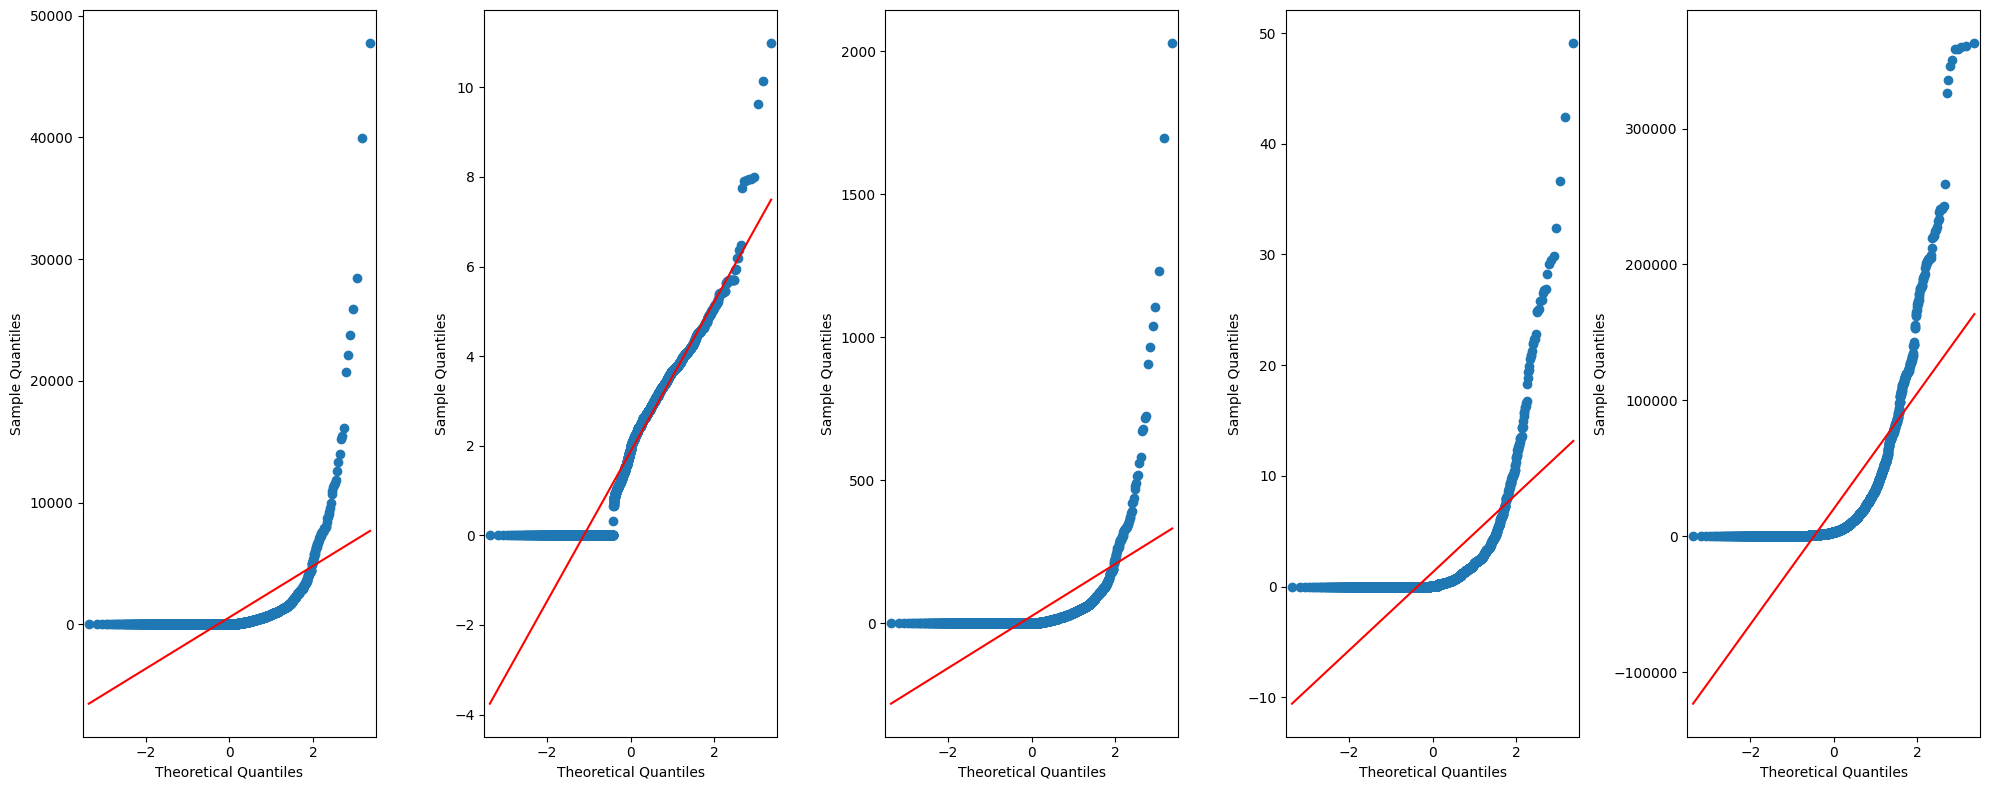

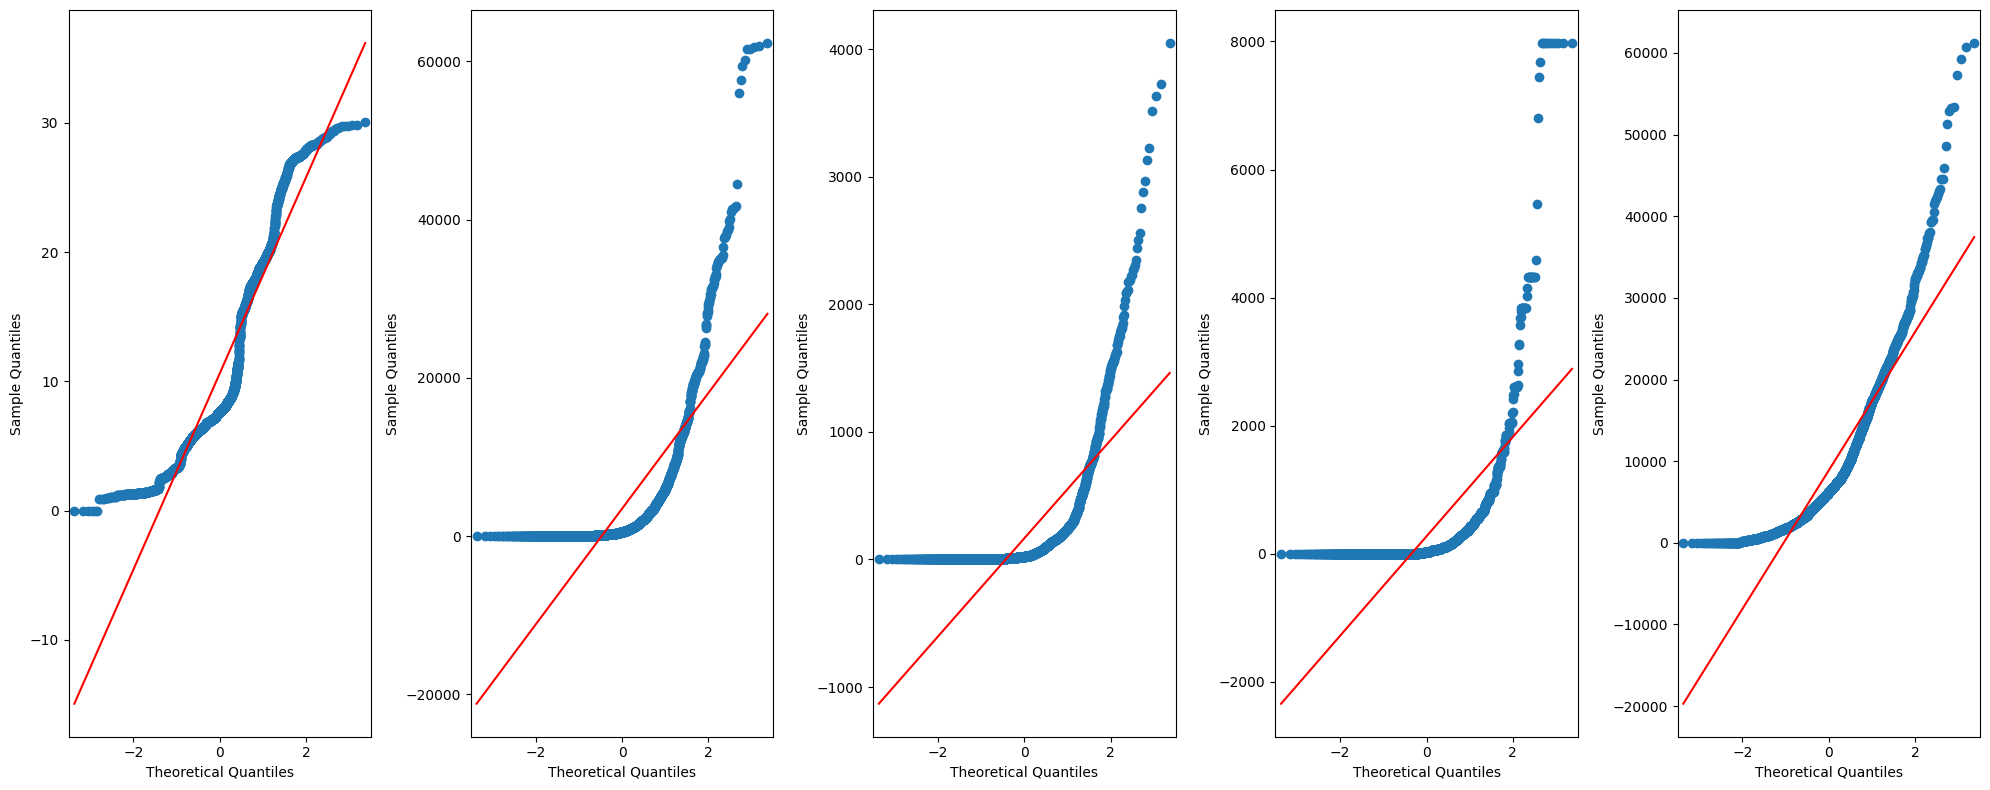

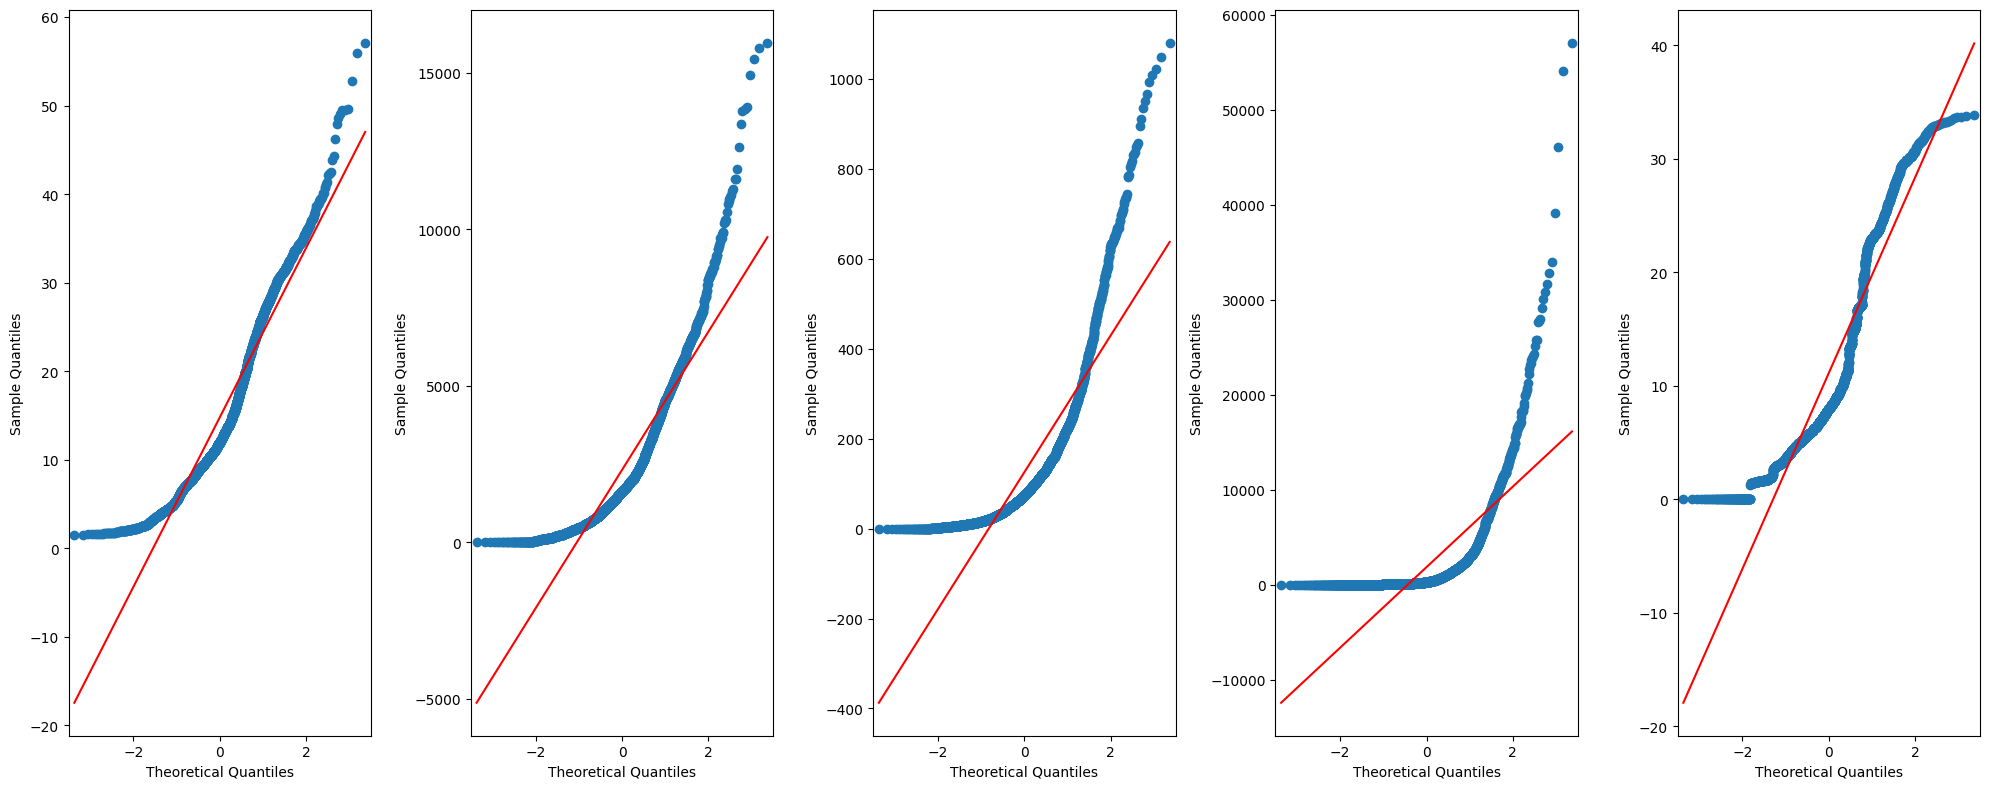

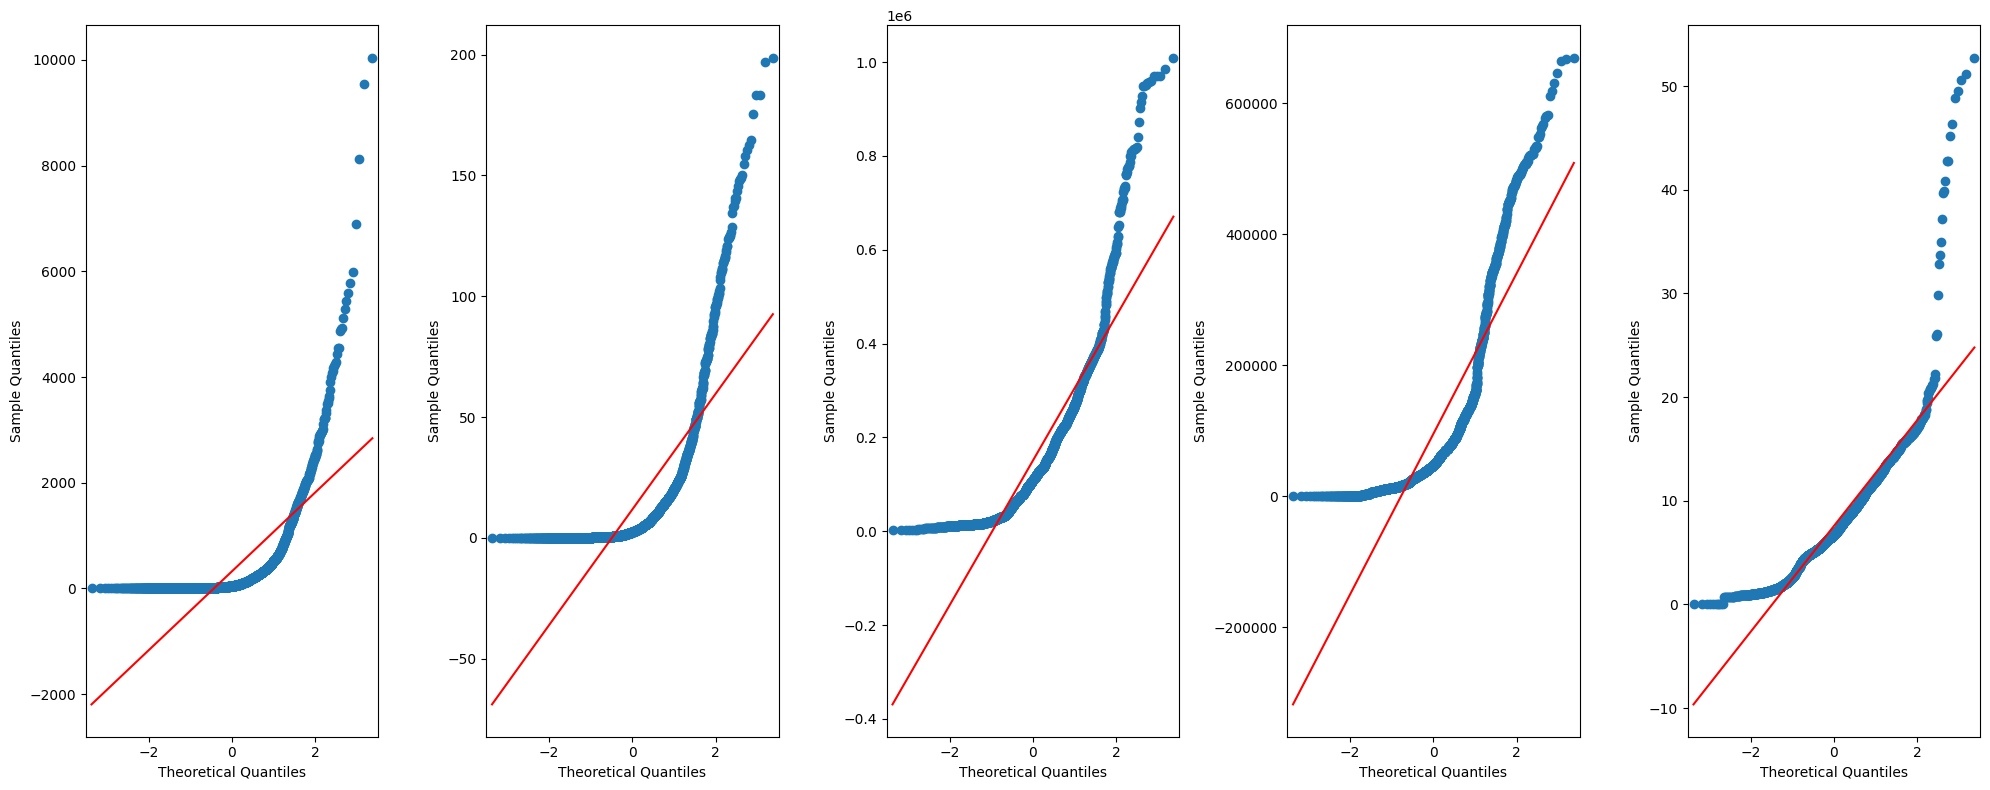

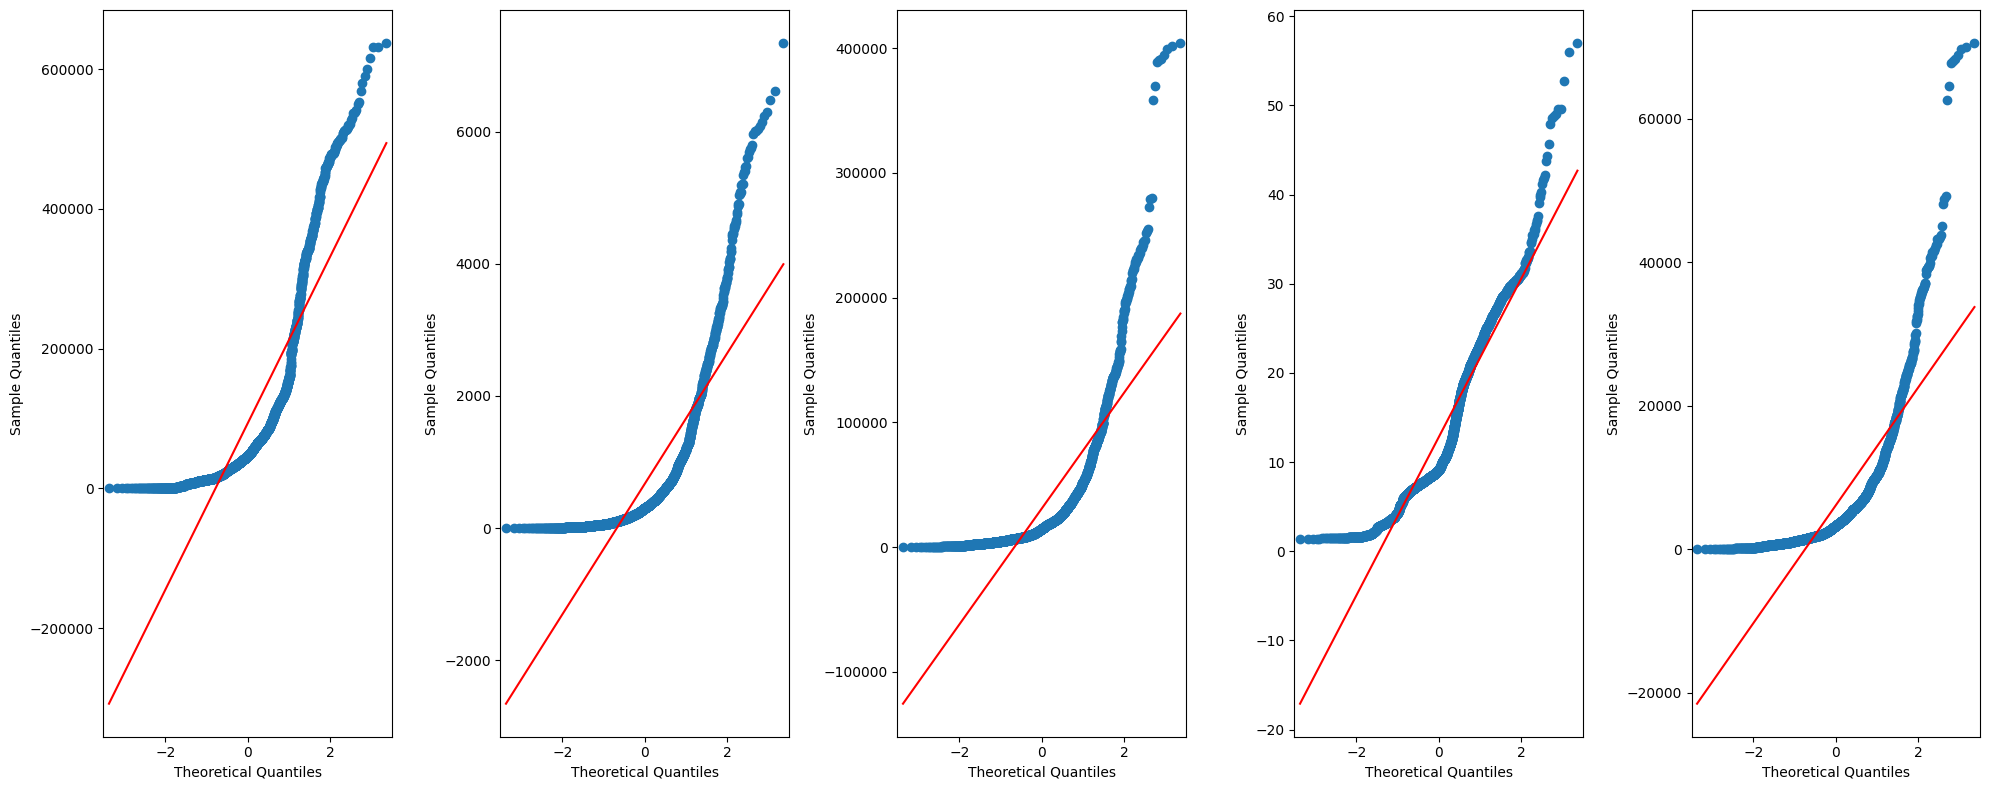

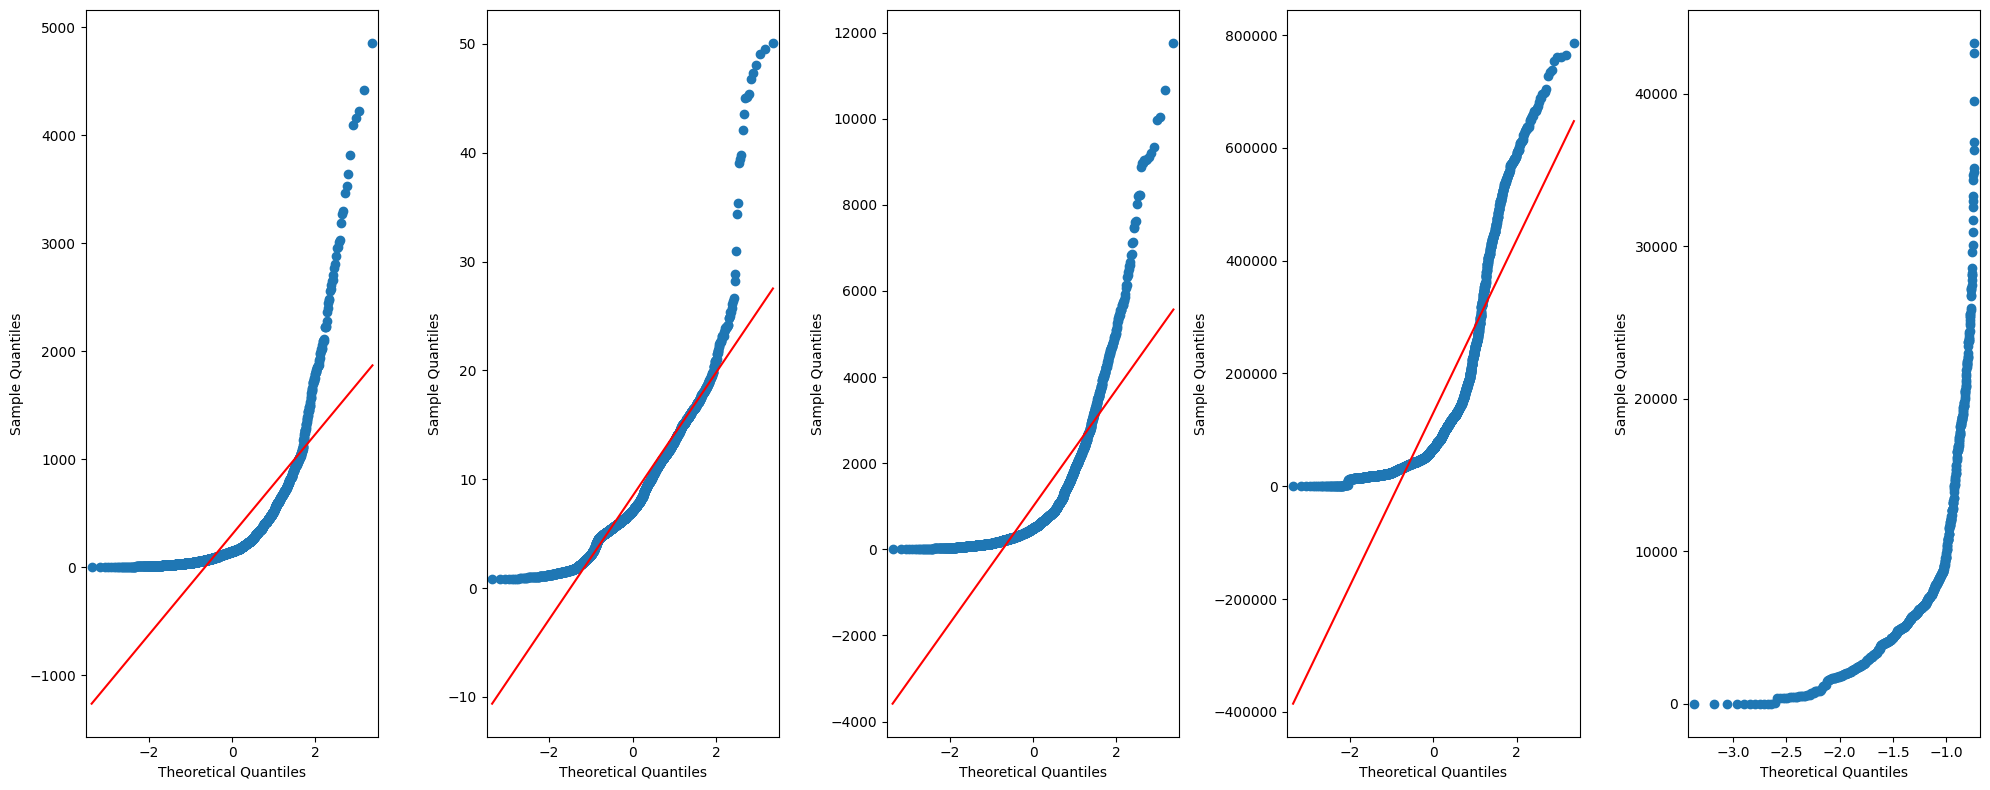

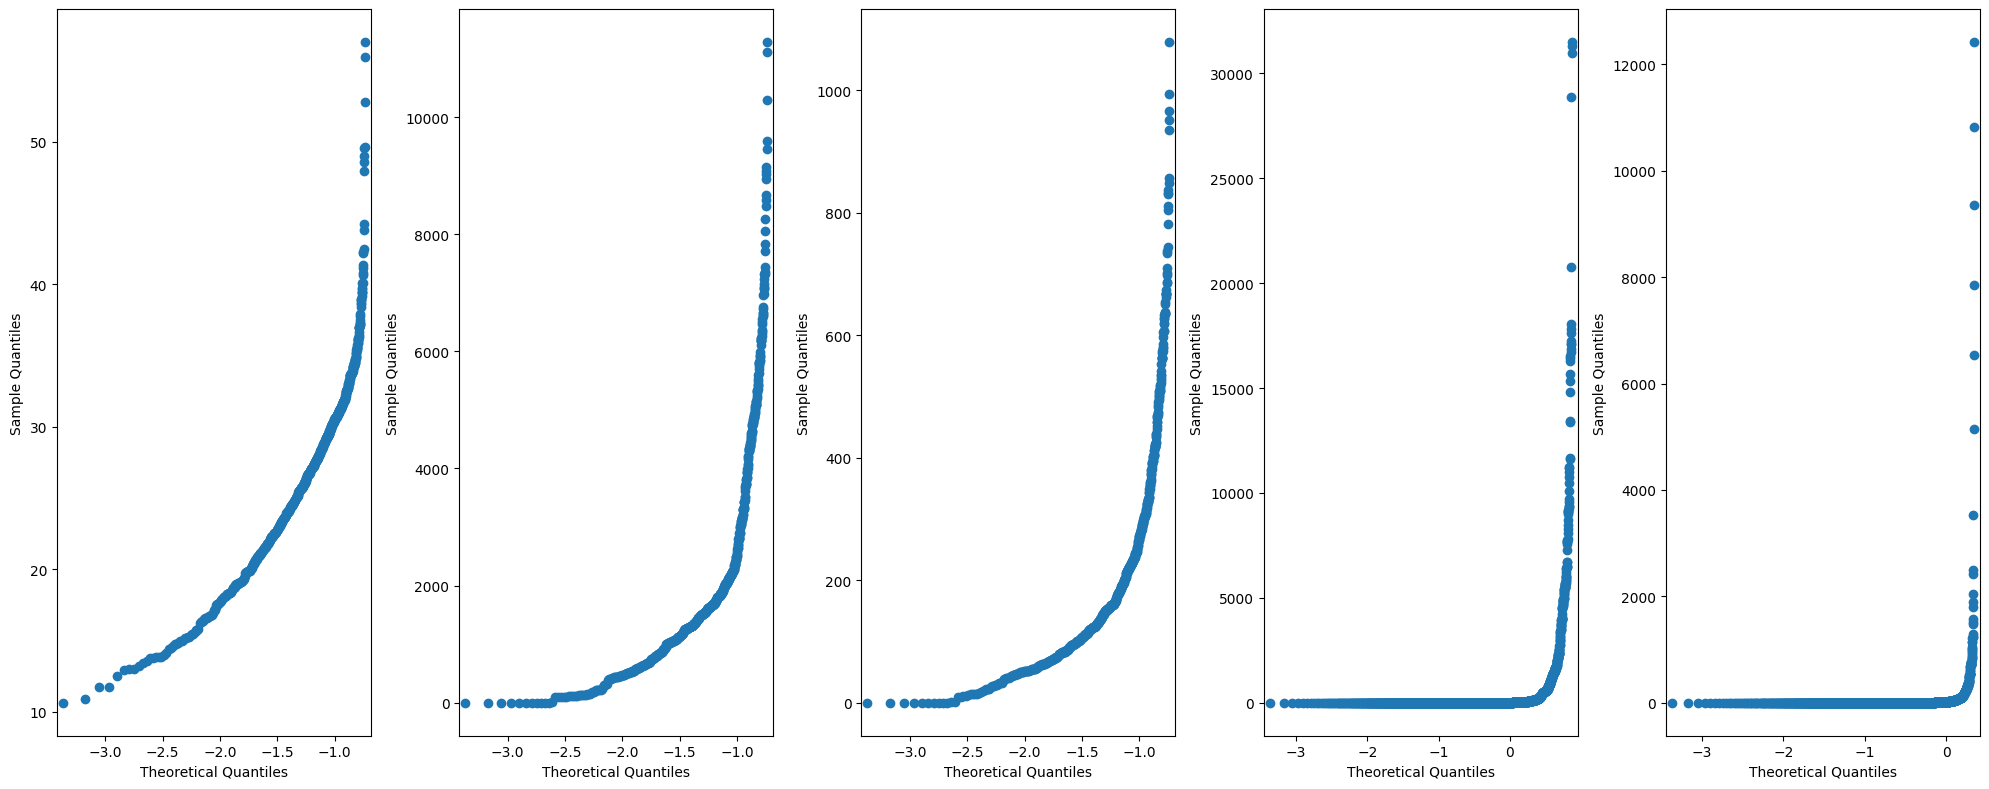

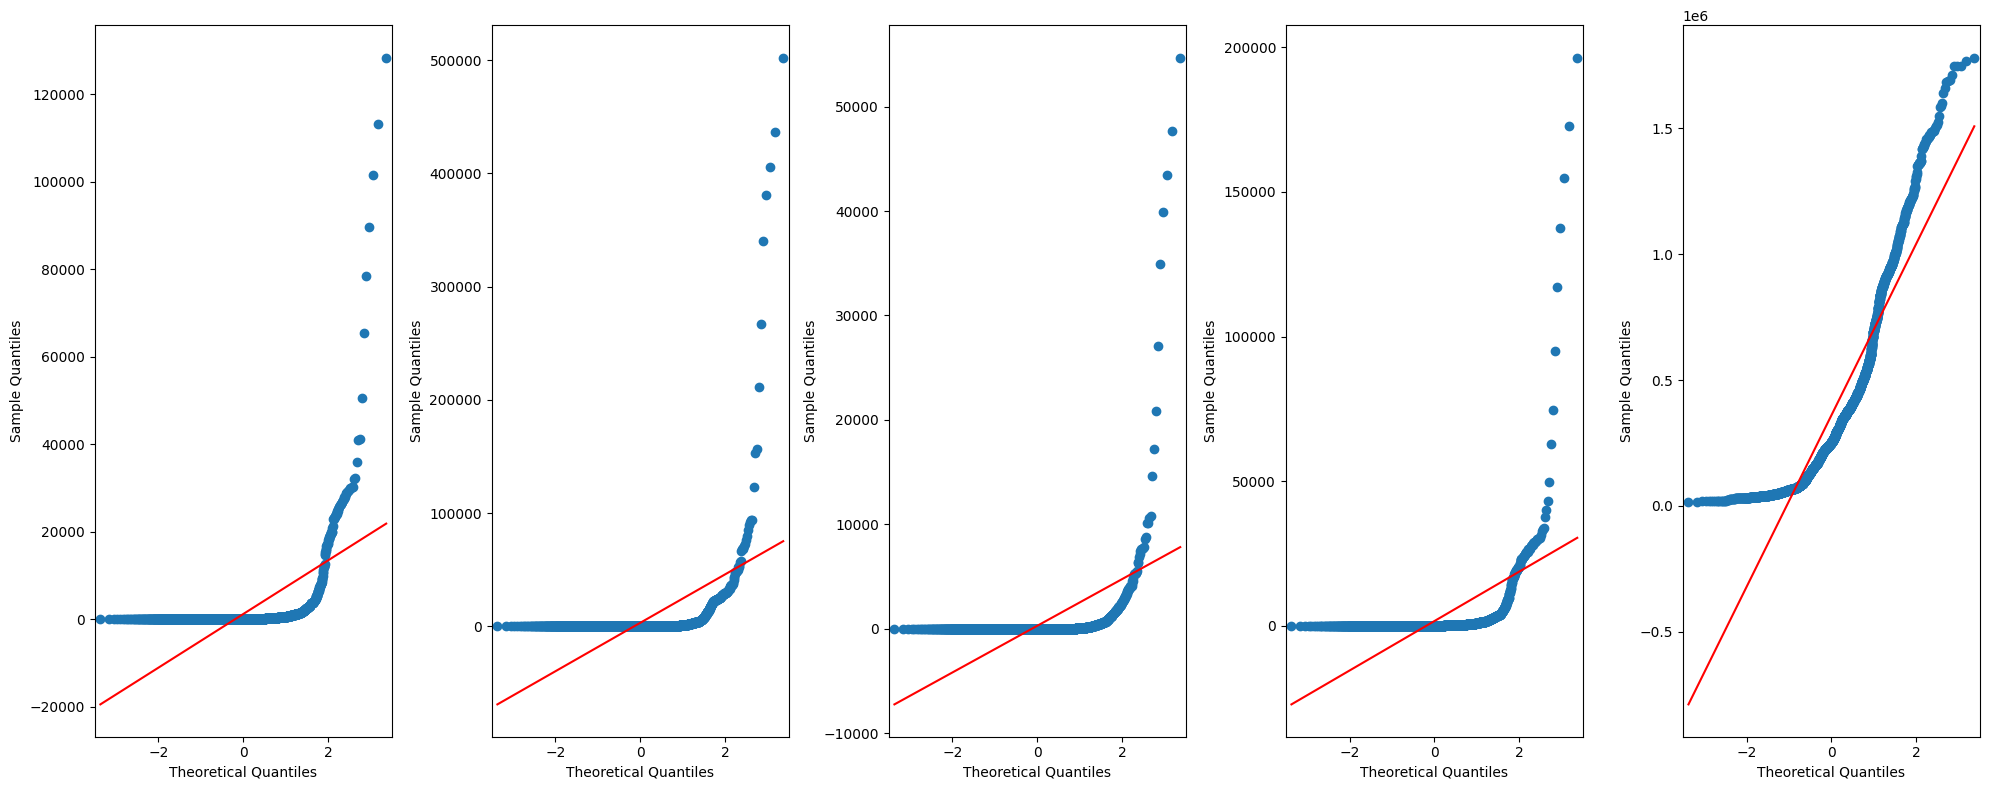

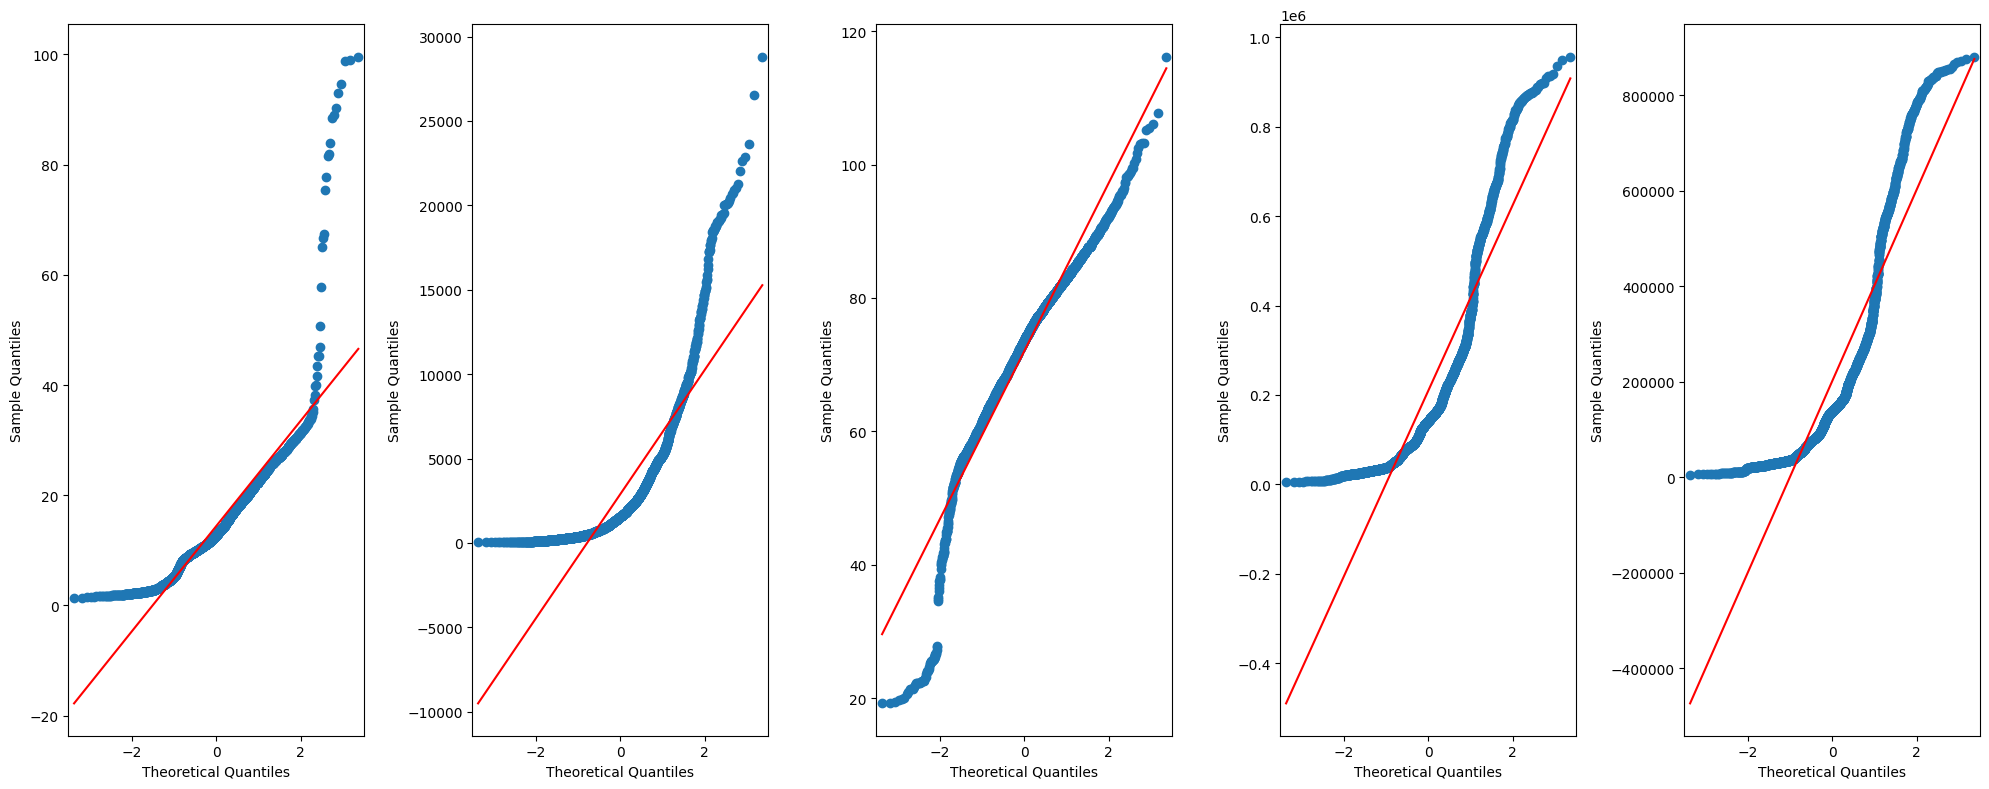

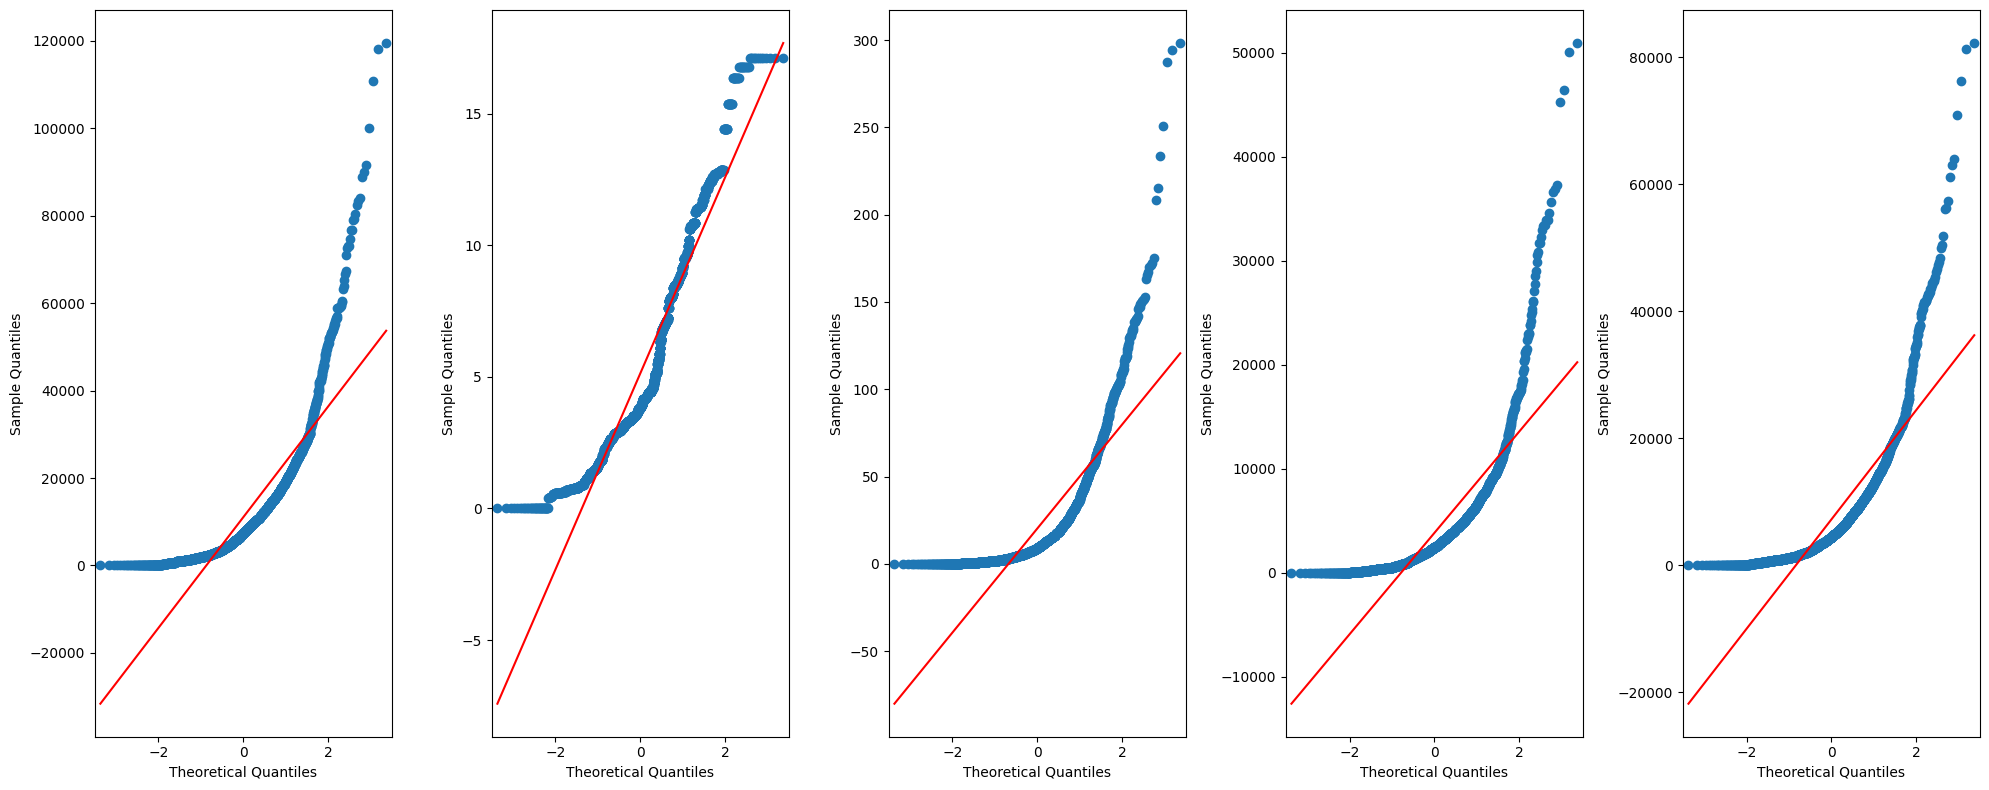

In [205]:
import statsmodels.api as sm
import pylab

figure, axes = plt.subplots(1, 5,figsize = (20,8))
for k,b in enumerate(needed_columns[:5]):
	sm.qqplot(needed_columns1[b], line='s', ax = axes[k])
	plt.tight_layout()
	
figure, axes = plt.subplots(1, 5,figsize = (20,8))
for k,b in enumerate(needed_columns[5:10]):
	sm.qqplot(needed_columns1[b], line='s', ax = axes[k])
	plt.tight_layout()
figure, axes = plt.subplots(1, 5,figsize = (20,8))
for k,b in enumerate(needed_columns[10:15]):
	sm.qqplot(needed_columns1[b], line='s', ax = axes[k])
	plt.tight_layout()
figure, axes = plt.subplots(1, 5,figsize = (20,8))
for k,b in enumerate(needed_columns[15:20]):
	sm.qqplot(needed_columns1[b], line='s', ax = axes[k])
	plt.tight_layout()
figure, axes = plt.subplots(1, 5,figsize = (20,8))
for k,b in enumerate(needed_columns[20:25]):
	sm.qqplot(needed_columns1[b], line='s', ax = axes[k])
	plt.tight_layout()
figure, axes = plt.subplots(1, 5,figsize = (20,8))
for k,b in enumerate(needed_columns[25:30]):
	sm.qqplot(needed_columns1[b], line='s', ax = axes[k])
	plt.tight_layout()
figure, axes = plt.subplots(1, 5,figsize = (20,8))
for k,b in enumerate(needed_columns[30:35]):
	sm.qqplot(needed_columns1[b], line='s', ax = axes[k])
	plt.tight_layout()
figure, axes = plt.subplots(1, 5,figsize = (20,8))
for k,b in enumerate(needed_columns[35:40]):
	sm.qqplot(needed_columns1[b], line='s', ax = axes[k])
	plt.tight_layout()
figure, axes = plt.subplots(1, 5,figsize = (20,8))
for k,b in enumerate(needed_columns[40:45]):
	sm.qqplot(needed_columns1[b], line='s', ax = axes[k])
	plt.tight_layout()
figure, axes = plt.subplots(1, 5,figsize = (20,8))
for k,b in enumerate(needed_columns[45:50]):
	sm.qqplot(needed_columns1[b], line='s', ax = axes[k])
	plt.tight_layout()

	
plt.show()
#pylab.show()

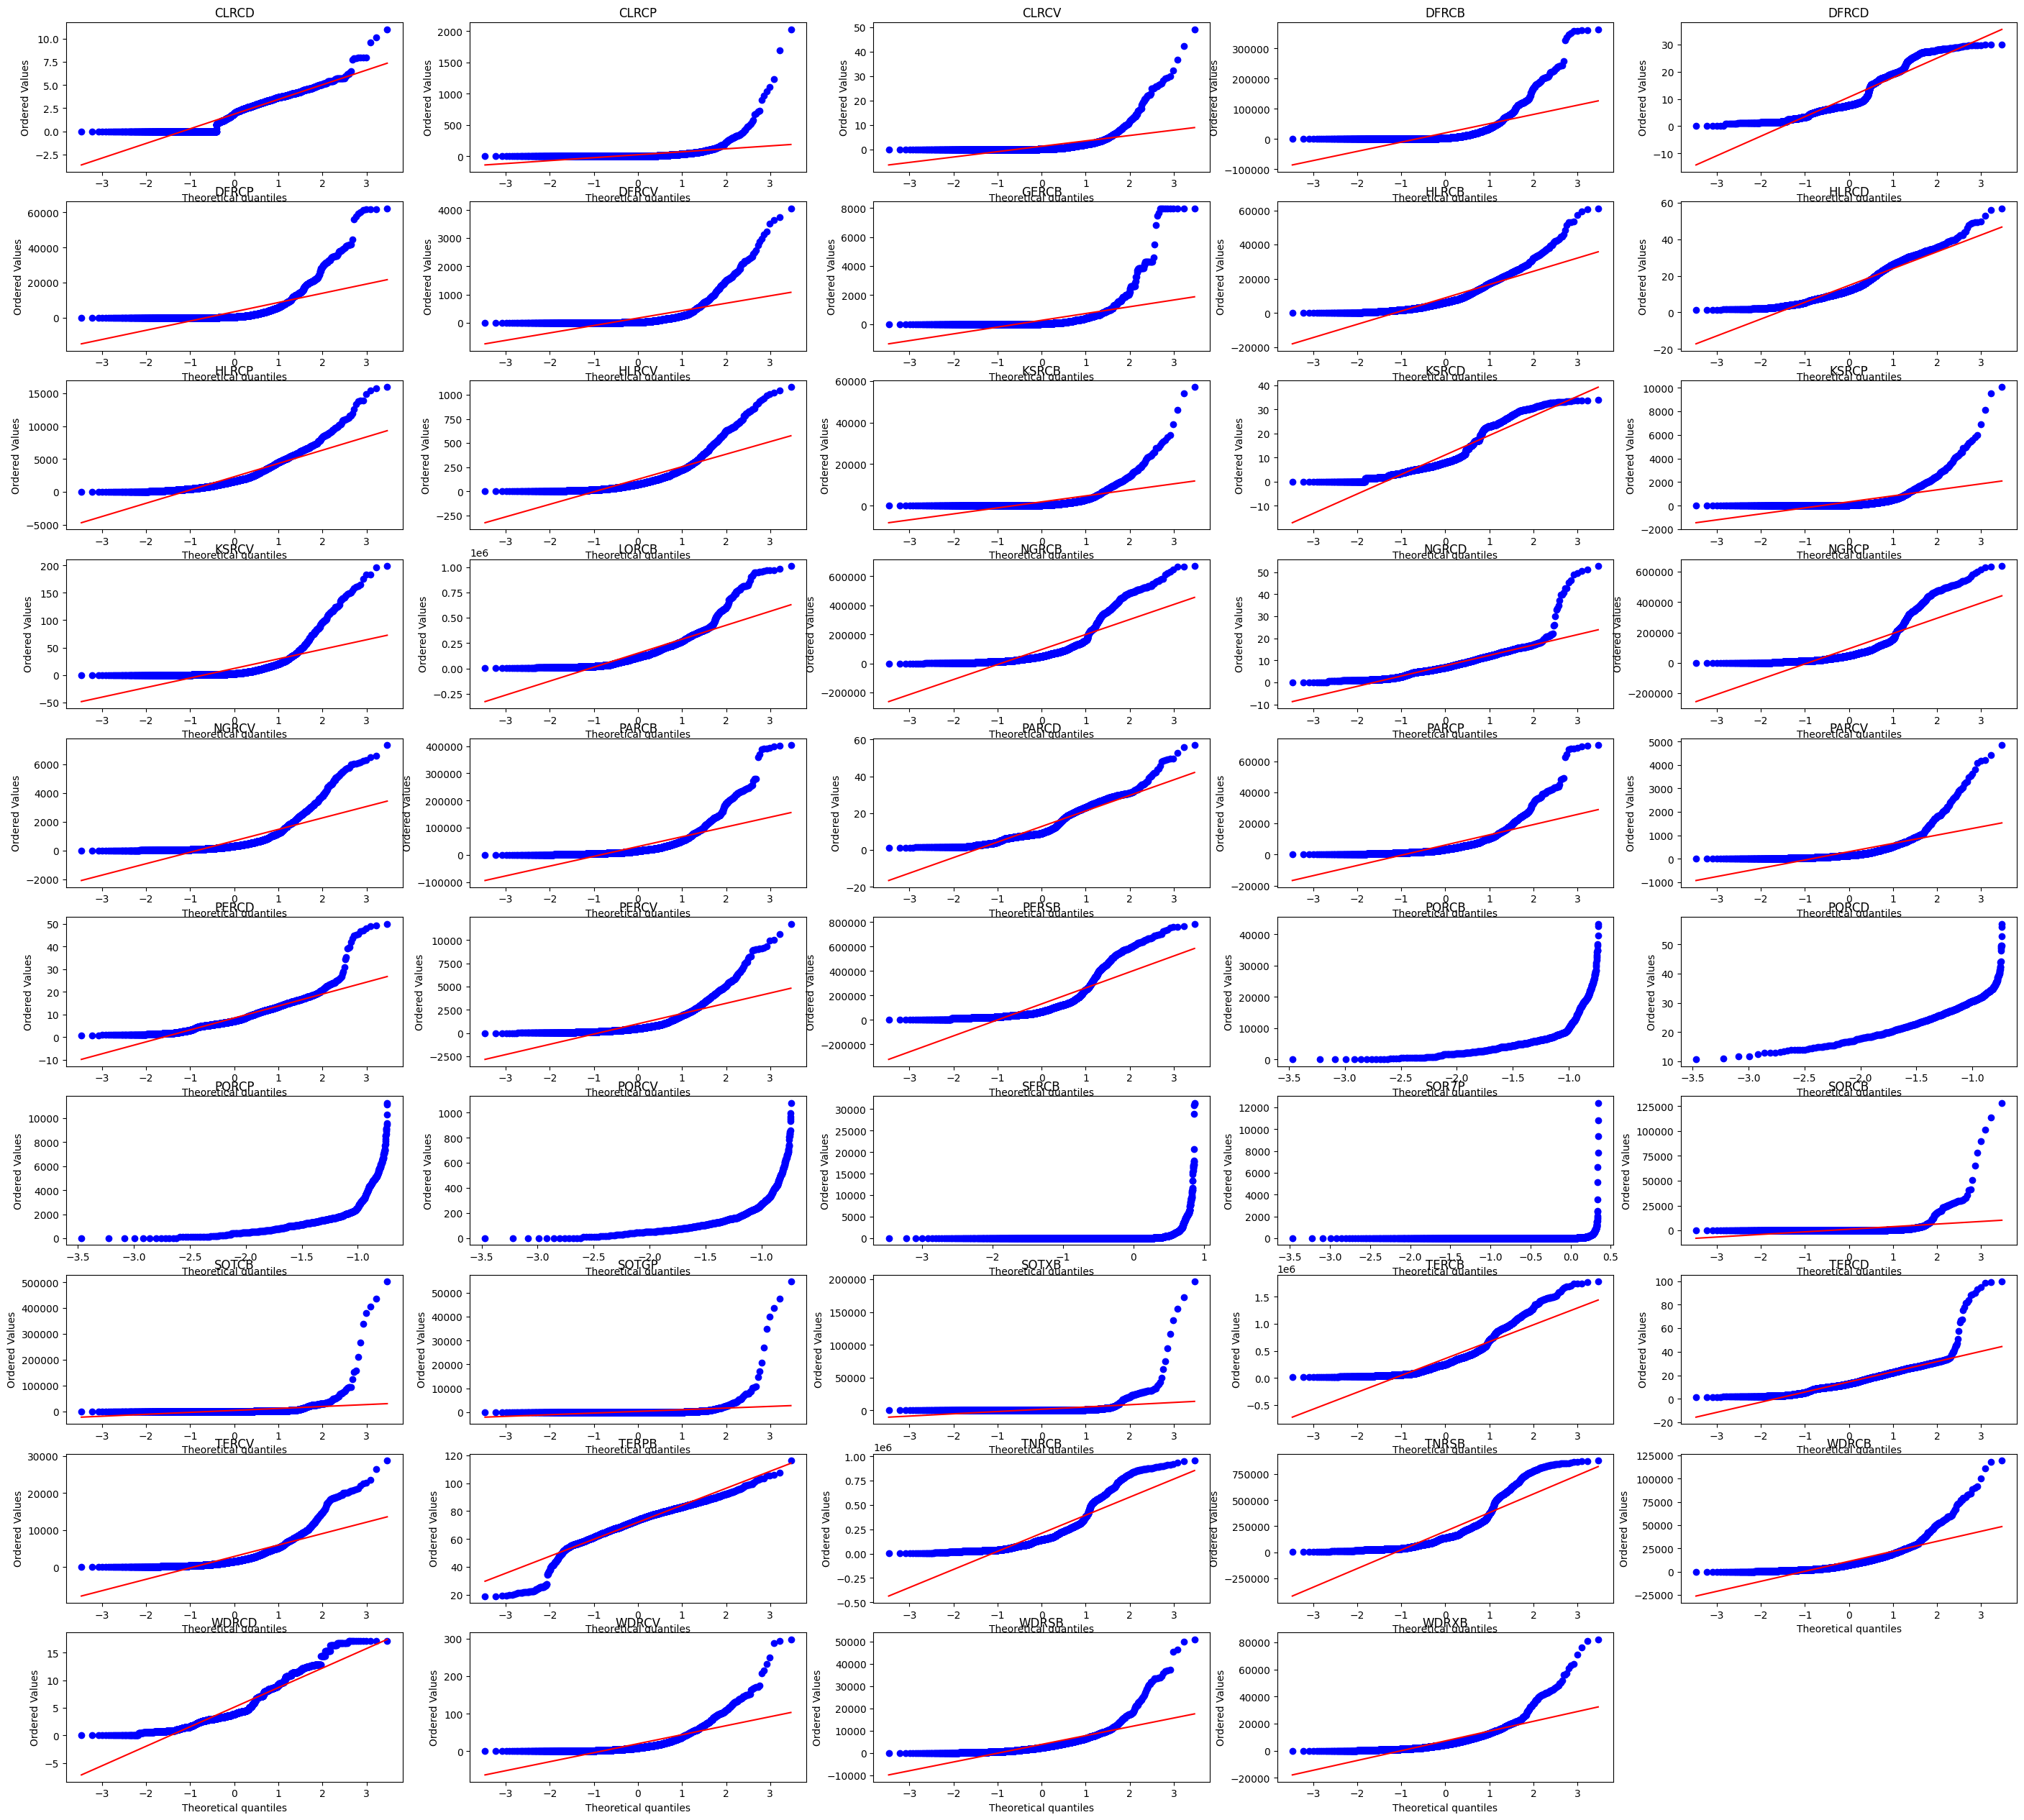

In [181]:
#This one works for plotting many plots. :) 

fig = plt.figure(figsize=(35,35))
for i,j in enumerate(needed_columns):
    if 0 < i < len(needed_columns):
        ax = fig.add_subplot(11,5 ,i)
        stats.probplot(needed_columns1[j], plot=pylab)
        ax.set_title(j)

In [183]:
merged_data

Data_Status  MSN_x StateCode       Year  Data_x  MSN_y  Data_y
0            2021F  ESRCV        AK 1970-01-01   16.70  CLRCB  233.00
1            2021F  ESRCV        AK 1970-01-01   16.70  CLRCD    2.47
2            2021F  ESRCV        AK 1970-01-01   16.70  CLRCP   13.00
3            2021F  ESRCV        AK 1970-01-01   16.70  CLRCV    0.60
4            2021F  ESRCV        AK 1970-01-01   16.70  DFRCB 7932.00
...            ...    ...       ...        ...     ...    ...     ...
122956       2021F  ESRCV        WY 2021-01-01  323.70  WDRCB 3769.00
122957       2021F  ESRCV        WY 2021-01-01  323.70  WDRCD   11.37
122958       2021F  ESRCV        WY 2021-01-01  323.70  WDRCV   18.00
122959       2021F  ESRCV        WY 2021-01-01  323.70  WDRSB 1587.00
122960       2021F  ESRCV        WY 2021-01-01  323.70  WDRXB 2183.00

[122961 rows x 7 columns]

In [191]:
import plotly.express as px


fig = px.box(merged_data, x="MSN_y", y="Data_y", title = "Summary of Financial Data", color = 'StateCode')
fig.show()

ModuleNotFoundError: No module named 'plotly'

<Axes: xlabel='MSN_y', ylabel='Data_y'>

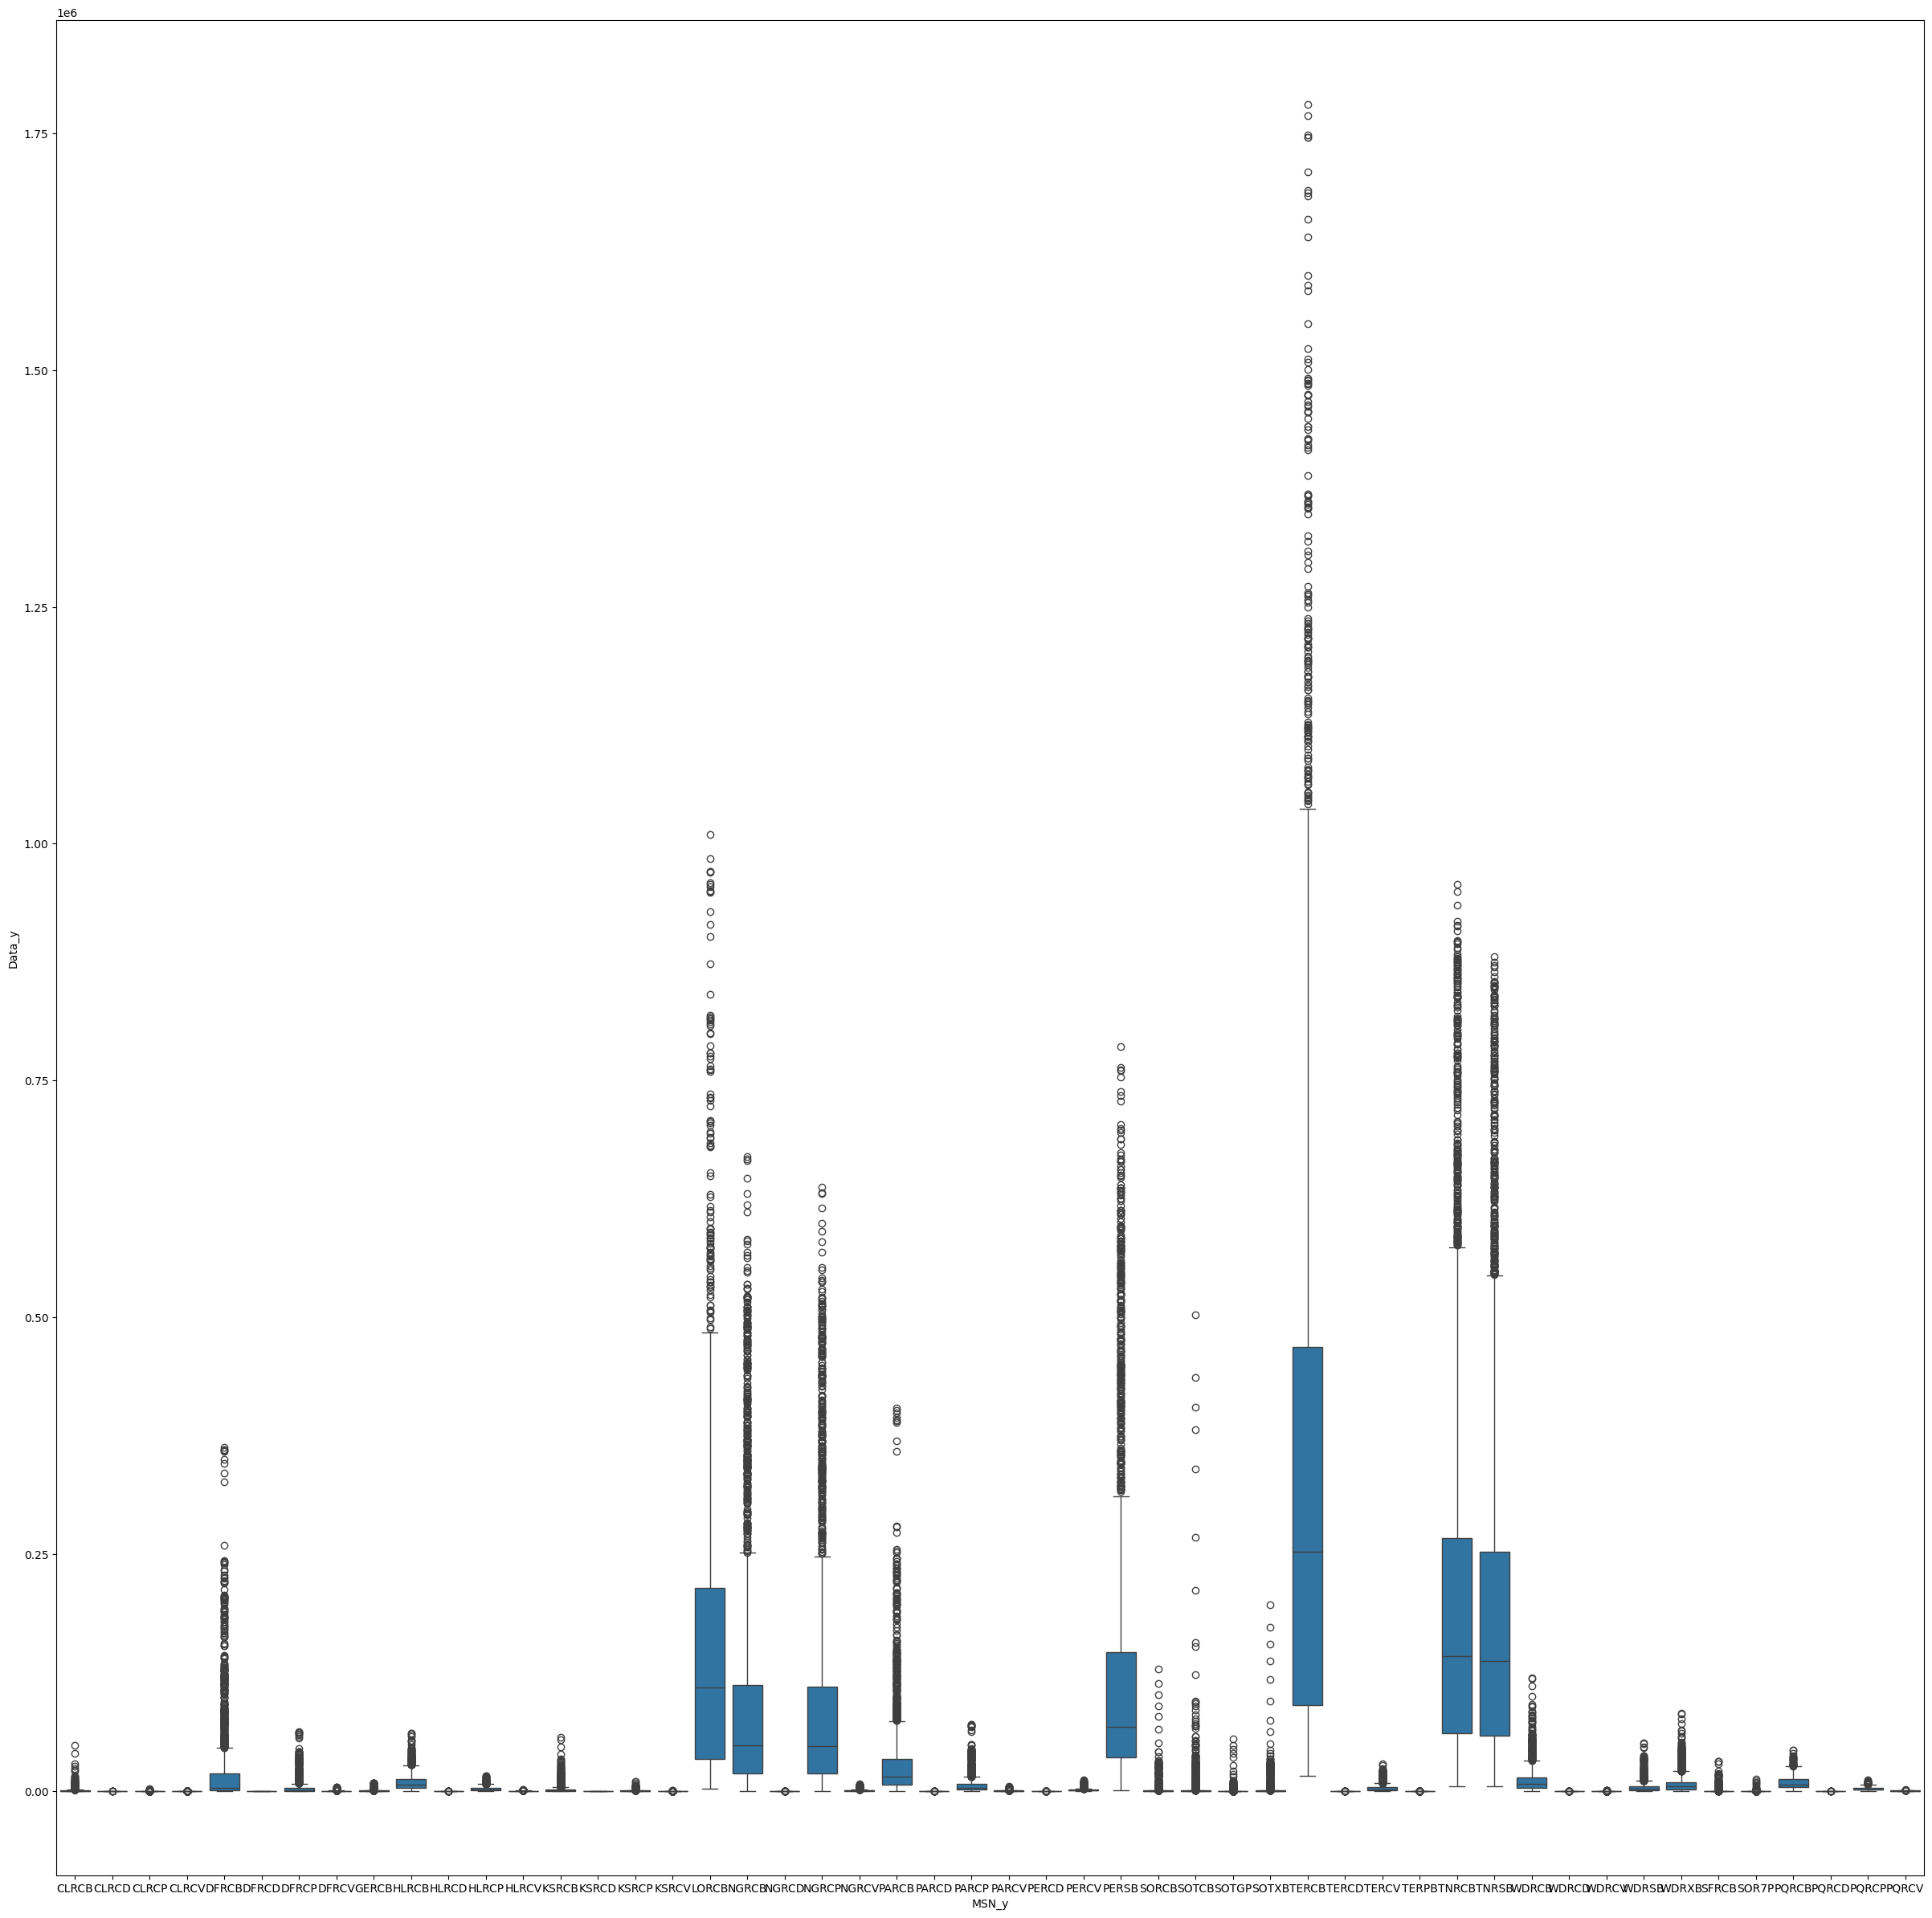

In [198]:
plt.figure(figsize=(30,30))
sns.boxplot(y='Data_y', x='MSN_y',data=merged_data)

In [20]:
## Correlation Coefficients maybe
newlist=[]
for i in needed_columns:
    newlist.append(['Annual Spending',i,(np.corrcoef(pivoted_data['Data_x'], pivoted_data[i]))])

In [21]:
corr = needed_columns1.corr()
corr.style.background_gradient(cmap='coolwarm',vmin=-1.0, vmax=1.0)

That is just wayy too big

In [22]:
fewer=corr[(corr <0.2)&(corr >-0.2)]

In [23]:
corr1=corr.reset_index(drop=True)

In [24]:
fewer=corr1[(corr1 <0.2)&(corr1 >-0.2)]

In [25]:
corr_result = corr.stack() #Using the corr function is neat
results_now=corr_result[(corr_result != 1.0)&((corr_result > 0.5))]

To start some values that are n

In [26]:
not_correlated_features=pd.DataFrame(results_now['Data_x']).reset_index()

In [27]:
list_of_features_to_keep=list(not_correlated_features['MSN_y'])

In [28]:
list_of_features_to_keep.append('Data_x')
list_of_features_to_keep.append('Year')


Now that I have a list of features that are going to be useful I need to compare them to each other

In [29]:
shorter_now = pivoted_data[list_of_features_to_keep]

In [30]:
corr1=shorter_now.corr()
corr1.style.background_gradient(cmap='coolwarm',vmin=-1.0, vmax=1.0)

In [31]:
list_of_features_to_keep.append('StateCode')

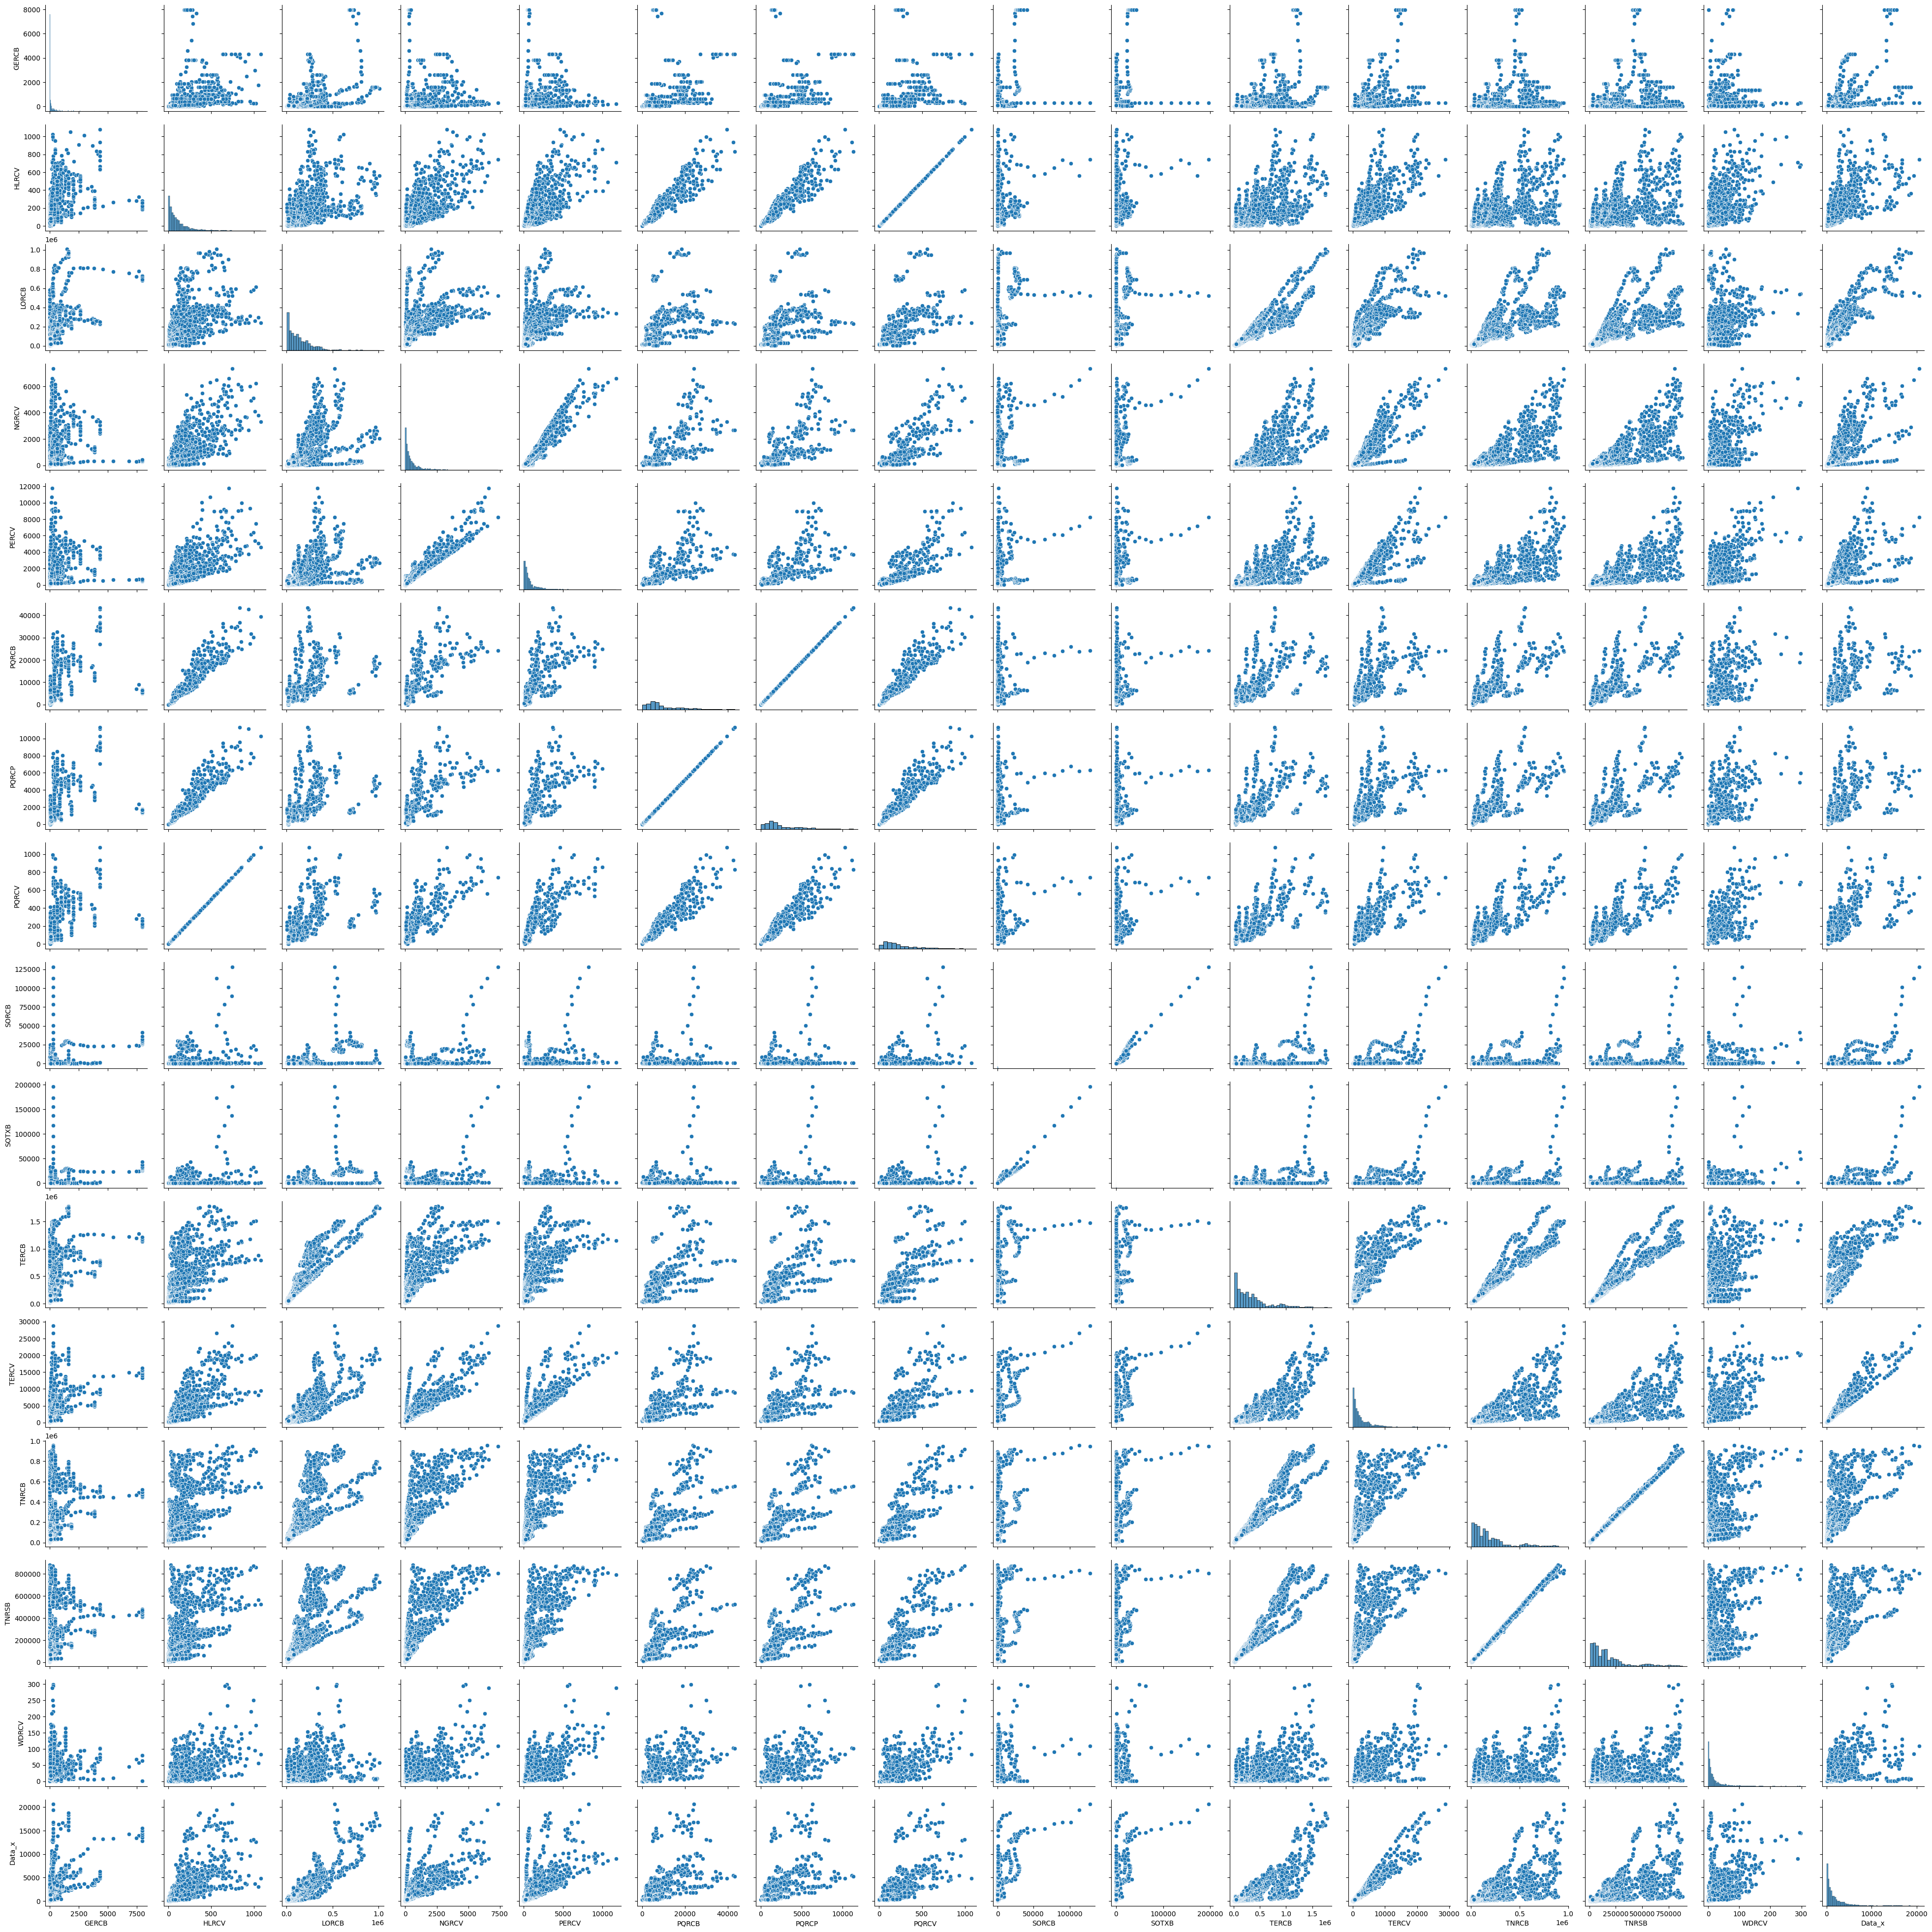

In [32]:
sns.pairplot(shorter_now)

For now going to apply model

In [33]:
shorter_now = pivoted_data[list_of_features_to_keep]

In [34]:
shorter_now= shorter_now.fillna(0)

In [35]:
#selected_column
shorter_now['Year1']=shorter_now['Year']
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(shorter_now['Year1'])
shorter_now['Year1'] =le.transform(shorter_now['Year1'])
le = LabelEncoder()
le.fit(shorter_now['StateCode'])
shorter_now['StateCode'] = le.transform(shorter_now['StateCode'])

In [36]:
# shift column 'Name' to first position 
first_column = shorter_now.pop('Year') 
  
# insert column using insert(position,column_name, 
# first_column) function 
shorter_now.insert(0, 'Year', first_column)

In [37]:
# shift column 'Name' to first position 
first_column = shorter_now.pop('Data_x') 
  
# insert column using insert(position,column_name, 
# first_column) function 
shorter_now.insert(0, 'Data_x', first_column)

In [38]:
shorter_now

MSN_y  Data_x       Year  GERCB  HLRCV    LORCB  NGRCV  PERCV   PQRCB  PQRCP  \
0       16.70 1970-01-01   0.00   0.60  7074.00   9.40  22.20    0.00   0.00   
1       20.10 1971-01-01   0.00   0.70  8316.00  10.60  27.70    0.00   0.00   
2       22.00 1972-01-01   0.00   0.80  8963.00  13.00  27.00    0.00   0.00   
3       22.30 1973-01-01   0.00   1.80  9488.00   7.90  27.40    0.00   0.00   
4       25.30 1974-01-01   0.00   1.20 10533.00   6.60  36.20    0.00   0.00   
...       ...        ...    ...    ...      ...    ...    ...     ...    ...   
2647   315.30 2017-01-01  70.00  82.10 20534.00 113.10 216.30 3505.00 913.00   
2648   310.20 2018-01-01  70.00  80.00 20438.00 113.00 216.40 3275.00 853.00   
2649   318.40 2019-01-01  70.00  74.20 21090.00 113.30 210.10 3513.00 915.00   
2650   319.90 2020-01-01  70.00  54.70 21385.00 114.60 186.30 2994.00 779.00   
2651   323.70 2021-01-01  70.00  82.10 21307.00 129.00 231.40 3351.00 873.00   

MSN_y  PQRCV  SORCB  SOTXB    TERCB  TERCV    TNRCB    TNRSB  WDRCV  \
0       0.00   0.00   0.00 24873.00  38.90 17800.00 16912.00   0.30   
1       0.00   0.00   0.00 29598.00  47.70 21282.00 20418.00   0.30   
2       0.00   0.00   0.00 29461.00  49.00 20497.00 19681.00   0.30   
3       0.00   0.00   0.00 28496.00  49.80 19008.00 18263.00   0.30   
4       0.00   0.00   0.00 29137.00  61.50 18605.00 17871.00   0.50   
...      ...    ...    ...      ...    ...      ...      ...    ...   
2647   82.10  28.00  45.00 51214.00 531.60 30680.00 28154.00  19.00   
2648   80.00  41.00  59.00 51489.00 526.60 31051.00 28500.00  21.10   
2649   74.20  61.00  84.00 53932.00 528.60 32842.00 30241.00  20.60   
2650   54.70  91.00 116.00 52335.00 506.20 30951.00 28498.00  15.80   
2651   82.10 132.00 160.00 52210.00 555.10 30903.00 28518.00  18.00   

MSN_y  StateCode  Year1  
0              0      0  
1              0      1  
2              0      2  
3              0      3  
4              0      4  
...          ...    ...  
2647          50     47  
2648          50     48  
2649          50     49  
2650          50     50  
2651          50     51  

[2652 rows x 19 columns]

In [39]:
X1 =shorter_now.loc[shorter_now['Year']<'2021-01-01']
X2 = shorter_now.loc[shorter_now['Year']>='2021-01-01']

In [40]:
y_train=X1['Data_x'].reset_index(drop=True) # Separating all of the data
y_test=X2['Data_x'].reset_index(drop=True)
X_train = X1.iloc[:,2: ]
X_test = X2.iloc[:,2: ]

In [41]:
X_train

MSN_y  GERCB  HLRCV    LORCB  NGRCV  PERCV   PQRCB  PQRCP  PQRCV  SORCB  \
0       0.00   0.60  7074.00   9.40  22.20    0.00   0.00   0.00   0.00   
1       0.00   0.70  8316.00  10.60  27.70    0.00   0.00   0.00   0.00   
2       0.00   0.80  8963.00  13.00  27.00    0.00   0.00   0.00   0.00   
3       0.00   1.80  9488.00   7.90  27.40    0.00   0.00   0.00   0.00   
4       0.00   1.20 10533.00   6.60  36.20    0.00   0.00   0.00   0.00   
...      ...    ...      ...    ...    ...     ...    ...    ...    ...   
2646   70.00  51.50 20329.00 102.10 169.70 2597.00 676.00  51.50  20.00   
2647   70.00  82.10 20534.00 113.10 216.30 3505.00 913.00  82.10  28.00   
2648   70.00  80.00 20438.00 113.00 216.40 3275.00 853.00  80.00  41.00   
2649   70.00  74.20 21090.00 113.30 210.10 3513.00 915.00  74.20  61.00   
2650   70.00  54.70 21385.00 114.60 186.30 2994.00 779.00  54.70  91.00   

MSN_y  SOTXB    TERCB  TERCV    TNRCB    TNRSB  WDRCV  StateCode  Year1  
0       0.00 24873.00  38.90 17800.00 16912.00   0.30          0      0  
1       0.00 29598.00  47.70 21282.00 20418.00   0.30          0      1  
2       0.00 29461.00  49.00 20497.00 19681.00   0.30          0      2  
3       0.00 28496.00  49.80 19008.00 18263.00   0.30          0      3  
4       0.00 29137.00  61.50 18605.00 17871.00   0.50          0      4  
...      ...      ...    ...      ...      ...    ...        ...    ...  
2646   33.00 49014.00 476.00 28686.00 26509.00  14.60         50     46  
2647   45.00 51214.00 531.60 30680.00 28154.00  19.00         50     47  
2648   59.00 51489.00 526.60 31051.00 28500.00  21.10         50     48  
2649   84.00 53932.00 528.60 32842.00 30241.00  20.60         50     49  
2650  116.00 52335.00 506.20 30951.00 28498.00  15.80         50     50  

[2601 rows x 17 columns]

In [42]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
scaler = StandardScaler()
scaler.fit(X_train)
X_test_scaled = scaler.transform(X_test)


In [43]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
linear_model1=linear_model.LinearRegression()
linear_model=LinearRegression().fit(X_train,y_train)
y_pred = linear_model.predict(X_test)
y_true =y_test

In [44]:
results_trial1=pd.DataFrame(y_pred,y_true).reset_index()
results_trial1

Data_x        0
0    469.90   469.90
1   4092.40  4092.40
2   2131.70  2131.70
3   4655.90  4655.91
4  20604.40 20604.43
5   2696.10  2696.10
6   2868.40  2868.39
7    330.90   330.91
8    647.10   647.10
9  15518.20 15518.19
10  7339.60  7339.60
11   946.20   946.30
12  1864.60  1864.60
13   944.60   944.70
14  6167.80  6167.81
15  4476.50  4476.50
16  1787.50  1787.50
17  3040.80  3040.80
18  3351.60  3351.70
19  4647.90  4647.89
20  3669.20  3669.20
21   861.60   861.60
22  6289.80  6289.79
23  3138.30  3138.30
24  4071.50  4071.50
25  2145.80  2145.80
26   623.90   624.00
27  6897.00  6897.09
28   530.30   530.41
29  1128.00  1128.00
30   959.20   959.29
31  4921.10  4921.10
32   958.10   958.10
33  1651.80  1651.80
34 10161.80 10161.69
35  6789.20  6789.19
36  2612.40  2612.50
37  2307.40  2307.30
38  7697.60  7697.59
39   698.40   698.40
40  4037.50  4037.40
41   616.50   616.50
42  4741.60  4741.60
43 18772.30 18772.29
44  1142.20  1142.21
45  5579.60  5579.49
46   418.70   418.80
47  3843.70  3843.70
48  3320.20  3320.30
49  1343.20  1343.30
50   323.70   323.70

In [45]:
results_trial1=pd.DataFrame(y_pred,y_true).reset_index()
results_trial1=results_trial1.rename(columns={'Data_x':'true',0:'predicted'})
results_trial1['how_off']= ((results_trial1['true']-results_trial1['predicted'])/results_trial1['true'])*100
results_trial1

true  predicted  how_off
0    469.90     469.90    -0.00
1   4092.40    4092.40    -0.00
2   2131.70    2131.70    -0.00
3   4655.90    4655.91    -0.00
4  20604.40   20604.43    -0.00
5   2696.10    2696.10    -0.00
6   2868.40    2868.39     0.00
7    330.90     330.91    -0.00
8    647.10     647.10    -0.00
9  15518.20   15518.19     0.00
10  7339.60    7339.60     0.00
11   946.20     946.30    -0.01
12  1864.60    1864.60    -0.00
13   944.60     944.70    -0.01
14  6167.80    6167.81    -0.00
15  4476.50    4476.50    -0.00
16  1787.50    1787.50    -0.00
17  3040.80    3040.80     0.00
18  3351.60    3351.70    -0.00
19  4647.90    4647.89     0.00
20  3669.20    3669.20     0.00
21   861.60     861.60     0.00
22  6289.80    6289.79     0.00
23  3138.30    3138.30    -0.00
24  4071.50    4071.50    -0.00
25  2145.80    2145.80     0.00
26   623.90     624.00    -0.02
27  6897.00    6897.09    -0.00
28   530.30     530.41    -0.02
29  1128.00    1128.00    -0.00
30   959.20     959.29    -0.01
31  4921.10    4921.10    -0.00
32   958.10     958.10     0.00
33  1651.80    1651.80    -0.00
34 10161.80   10161.69     0.00
35  6789.20    6789.19     0.00
36  2612.40    2612.50    -0.00
37  2307.40    2307.30     0.00
38  7697.60    7697.59     0.00
39   698.40     698.40    -0.00
40  4037.50    4037.40     0.00
41   616.50     616.50    -0.00
42  4741.60    4741.60    -0.00
43 18772.30   18772.29     0.00
44  1142.20    1142.21    -0.00
45  5579.60    5579.49     0.00
46   418.70     418.80    -0.02
47  3843.70    3843.70     0.00
48  3320.20    3320.30    -0.00
49  1343.20    1343.30    -0.01
50   323.70     323.70     0.00